Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import nnls
from collections import defaultdict
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

Preparing Data

In [2]:
prices_df = pd.read_csv('data\Russell3000_prices_clean.csv')
prices_df['Date'] = pd.to_datetime(prices_df['Date'], dayfirst=True)
prices_df.sort_values(by='Date', inplace=True)  # prices_df is modified in place, and there's no new DataFrame returned

selected_stocks = prices_df.columns[1:3]

Returns of Selected Stocks

In [3]:
returns_df = pd.DataFrame(index=prices_df.index)
returns_df['Date'] = prices_df['Date']

stock_returns_df = []
# Iterate over selected stocks
for stock in selected_stocks:
    # Calculate returns for the stock
    stock_returns = prices_df[stock].pct_change()

    # Append the stock's returns DataFrame to the list
    stock_returns_df.append(pd.DataFrame({stock: stock_returns}))

# Concatenate all the stock's returns DataFrames into a single DataFrame
returns_df = pd.concat([returns_df] + stock_returns_df, axis=1).dropna().reset_index(drop=True)

del stock_returns_df

In [4]:
'''x = 0
y = 0
for stock in selected_stocks:
    x += returns_df[stock].std()*252**0.5
    y += 1
print(x/y)'''

'x = 0\ny = 0\nfor stock in selected_stocks:\n    x += returns_df[stock].std()*252**0.5\n    y += 1\nprint(x/y)'

Volatility Estimators' Correlation Table

In [5]:
# Create an empty DataFrame with the desired columns
correlations_df = [["Estimators", "T=12m", "T=6m", "T=3m", "T=1m"]]

SAMPLE

In [6]:
def calculate_rolling_std(data, window):
    n = len(data)
    std_values = [data[i-window:i].std() if i >= window else None for i in range(n)]
    return pd.Series(std_values, index=data.index)

'''def sample_corr(returns=returns_df, stocks=selected_stocks,  windows = [21*12, 21*6, 21*3, 21*1]):
    volatility_in_sample = pd.DataFrame(index=returns.index)
    volatility_in_sample['Date'] = returns['Date']
    volatility_out_of_sample = pd.DataFrame(index=returns.index)
    volatility_out_of_sample['Date'] = returns['Date']
    # Define the window size for monthly calculations
    window_out_of_sample = 21  # 21 trading days in a month

    correlations = ['SAMPLE']

    for window in windows:
        # Calculate volatility rolling window
        for stock in stocks:
            volatility_in_sample[stock] = returns[stock].rolling(window=window).std()
            volatility_out_of_sample[stock] = returns[stock].rolling(window=window_out_of_sample).std()

        # Trim the DataFrames to match the length of the smaller rolling window
        volatility_in_sample = volatility_in_sample.iloc[window:]
        volatility_in_sample = volatility_in_sample.iloc[:-window_out_of_sample].dropna().reset_index(drop=True)
        volatility_out_of_sample = volatility_out_of_sample.iloc[window_out_of_sample + window:].reset_index(drop=True)

    
        correlation = {}
        for stock in selected_stocks:
            in_sample_volatility = volatility_in_sample[stock]
            out_of_sample_volatility = volatility_out_of_sample[stock]
            correlation[stock] = in_sample_volatility.corr(out_of_sample_volatility)

        correlations.append(sum(correlation.values()) / len(correlation))
    return correlations


correlations_df.append(sample_corr())'''

"def sample_corr(returns=returns_df, stocks=selected_stocks,  windows = [21*12, 21*6, 21*3, 21*1]):\n    volatility_in_sample = pd.DataFrame(index=returns.index)\n    volatility_in_sample['Date'] = returns['Date']\n    volatility_out_of_sample = pd.DataFrame(index=returns.index)\n    volatility_out_of_sample['Date'] = returns['Date']\n    # Define the window size for monthly calculations\n    window_out_of_sample = 21  # 21 trading days in a month\n\n    correlations = ['SAMPLE']\n\n    for window in windows:\n        # Calculate volatility rolling window\n        for stock in stocks:\n            volatility_in_sample[stock] = returns[stock].rolling(window=window).std()\n            volatility_out_of_sample[stock] = returns[stock].rolling(window=window_out_of_sample).std()\n\n        # Trim the DataFrames to match the length of the smaller rolling window\n        volatility_in_sample = volatility_in_sample.iloc[window:]\n        volatility_in_sample = volatility_in_sample.iloc[:-window

In [7]:
'''def sample_corrs(returns=returns_df, stocks=selected_stocks,  windows = [21*12, 21*6, 21*3, 21*1]):
    volatility_in_sample = pd.DataFrame(index=returns.index)
    volatility_in_sample['Date'] = returns['Date']
    volatility_out_of_sample = pd.DataFrame(index=returns.index)
    volatility_out_of_sample['Date'] = returns['Date']
    # Define the window size for monthly calculations
    window_out_of_sample = 21  # 21 trading days in a month

    correlations = []

    for window in windows:
        # Calculate annual volatility using a 252-day rolling window
        for stock_symbol in stocks:
            volatility_in_sample[stock_symbol] = returns[stock_symbol].rolling(window=window).std()

        # Calculate monthly volatility using a 21-day rolling window
        for stock_symbol in stocks:
            volatility_out_of_sample[stock_symbol] = returns[stock_symbol].rolling(window=window_out_of_sample).std()

        # Trim the DataFrames to match the length of the smaller rolling window
        volatility_in_sample = volatility_in_sample.tail(len(volatility_in_sample) - window)
        volatility_in_sample = volatility_in_sample.head(len(volatility_in_sample) - window_out_of_sample).reset_index(drop=True)
        volatility_out_of_sample = volatility_out_of_sample.tail(len(volatility_out_of_sample) - (window_out_of_sample + window)).reset_index(drop=True)

    
        correlation = {}
        for stock_symbol in selected_stocks:
            in_sample_volatility = volatility_in_sample[stock_symbol]
            out_of_sample_volatility = volatility_out_of_sample[stock_symbol]
            correlation[stock_symbol] = in_sample_volatility.corr(out_of_sample_volatility)

        correlations.append(sum(correlation.values()) / len(correlation))
    return correlations

print(sample_corrs())'''

"def sample_corrs(returns=returns_df, stocks=selected_stocks,  windows = [21*12, 21*6, 21*3, 21*1]):\n    volatility_in_sample = pd.DataFrame(index=returns.index)\n    volatility_in_sample['Date'] = returns['Date']\n    volatility_out_of_sample = pd.DataFrame(index=returns.index)\n    volatility_out_of_sample['Date'] = returns['Date']\n    # Define the window size for monthly calculations\n    window_out_of_sample = 21  # 21 trading days in a month\n\n    correlations = []\n\n    for window in windows:\n        # Calculate annual volatility using a 252-day rolling window\n        for stock_symbol in stocks:\n            volatility_in_sample[stock_symbol] = returns[stock_symbol].rolling(window=window).std()\n\n        # Calculate monthly volatility using a 21-day rolling window\n        for stock_symbol in stocks:\n            volatility_out_of_sample[stock_symbol] = returns[stock_symbol].rolling(window=window_out_of_sample).std()\n\n        # Trim the DataFrames to match the length of 

Exponential Weighted Variance Estimator

In [8]:
# def get_exp_weights(size, const=0.94):

#     weights = [const**i for i in range(1, size + 1)]
#     suma = sum(weights)
#     weights = [weight / suma for weight in weights]

#     return weights


# def ewma (weights, returns):
#     variance = sum(weights * returns**2)
#     return variance**0.5
    
# def EWMA (selected_stocks = selected_stocks, returns = returns_df, windows = [21*12, 21*6, 21*3, 21*1]):
#     volatility_out_of_sample = pd.DataFrame(index=returns.index)
#     volatility_out_of_sample['Date'] = returns['Date']
#     window_out_of_sample = 21  # 21 trading days in a month
  
#     # Define the window size for monthly calculations
#     correlations = ['EWMA']
#     for window in windows:
#         weights = get_exp_weights(window)
#         correlation = {}
#         # Calculate monthly volatility using a 21-day rolling window
#         for stock_symbol in selected_stocks:
#             value = []

#             for i in range(len(returns[stock_symbol]) - window - window_out_of_sample):
                
#                 window_returns = returns[stock_symbol][i:i + len(weights)]
#                 window_returns = window_returns[::-1]
#                 value.append(lstsq(weights, window_returns))
            
#             value = value[0:]
#             print(value)

#             volatility_out_of_sample[stock_symbol] = returns[stock_symbol].rolling(window=window_out_of_sample).std()

#             vola1 = volatility_out_of_sample[stock_symbol].tail(len(volatility_out_of_sample) - (window_out_of_sample + window)).reset_index(drop=True)
#             print(vola1)
#             correlation[stock_symbol] = np.corrcoef(vola1, value)[0, 1]
#         correlations.append(sum(correlation.values()) / len(correlation))
#     return correlations

# correlations_df.append(EWMA())

Portfelj

6.263626960177163


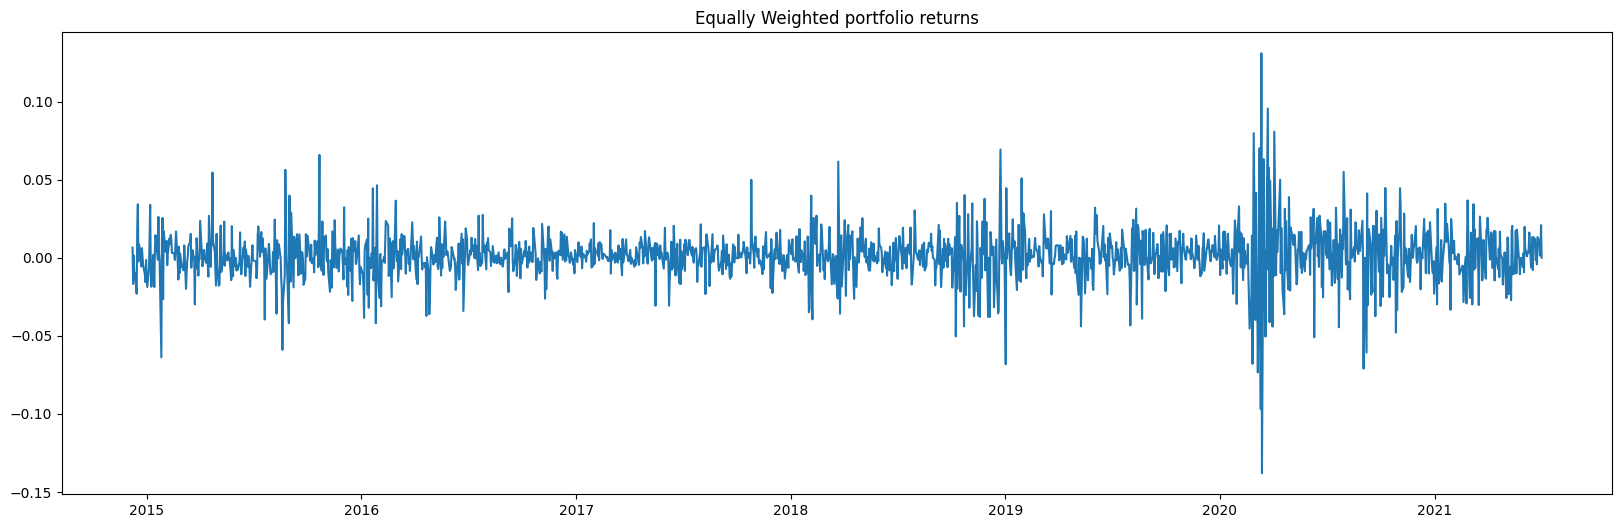

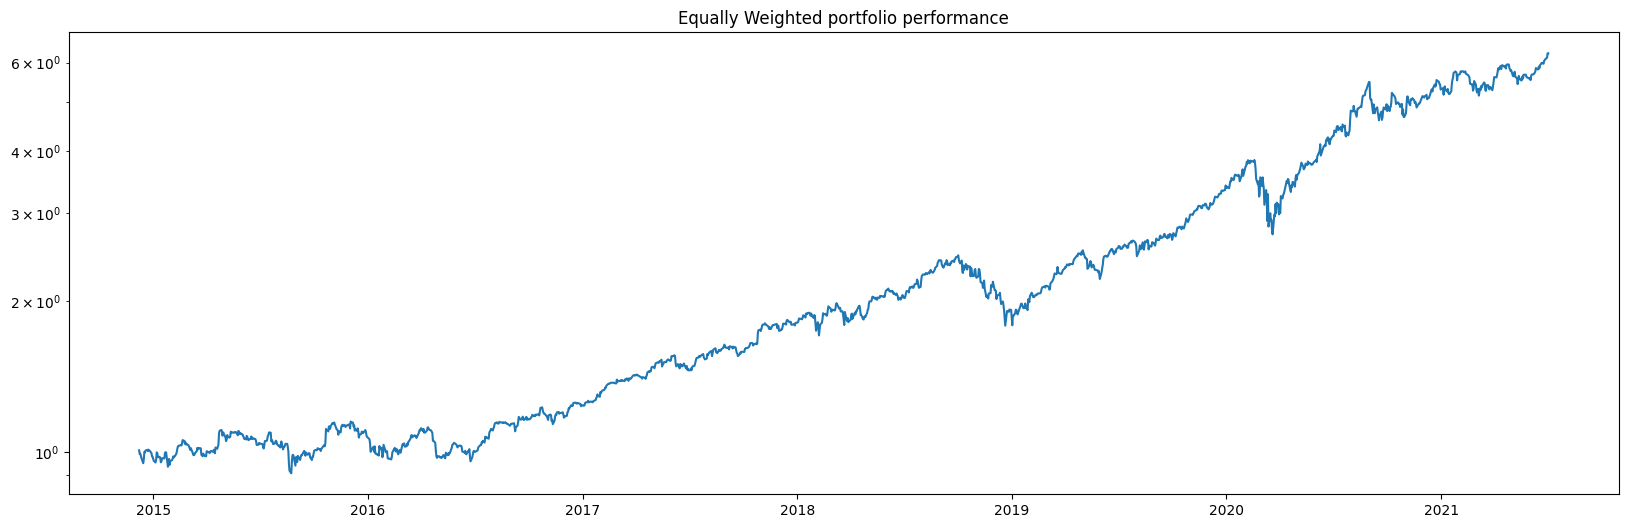

In [9]:
def get_portf_weights(volatility):
    zbroj = 0
    weights = np.array([])

    for stock in selected_stocks:
        if volatility[stock] > 0:
            zbroj = zbroj + 1 / volatility[stock]

    for stock in selected_stocks:   
        if volatility[stock] > 0:
            weights = np.append(weights, (1 / volatility[stock]) / zbroj)
        else:
            weights = np.append(weights, 0)

    return weights

matrix = returns_df.iloc[:, 1:].to_numpy()
window = 21*12
start = 0 + 252*15
end = len(prices_df) -21-252*0
ukupno_eq = [1]
povrat_eq = []

for i in range(start, end, 21):
    real_end = i + 20
    volatility = {}
    for stock in selected_stocks:
        volatility[stock] = 1
    
    #racunamo tezine s obzirom na volatility
    weights = get_portf_weights(volatility) # 1/len(volatility)
    #za svaki dan racunamo promjenu u portfelju

    vector = weights
    eq_returns = np.dot(matrix[i:i+21], vector)
    for ret in eq_returns:
        povrat_eq.append(ret)
        ukupno_eq.append((ret+1)*ukupno_eq[-1])

print(ukupno_eq[-1])
dates = returns_df.iloc[start-1:real_end, 0]

plt.figure(figsize=(20, 6))
plt.plot(dates, povrat_eq)
plt.title("Equally Weighted portfolio returns")
plt.show()

plt.figure(figsize=(20, 6))
plt.semilogy(dates, ukupno_eq[1:])
plt.title("Equally Weighted portfolio performance")
plt.show()

In [10]:
predicted_lsq_volatility = defaultdict(list)
observed_volatility = defaultdict(list)
predicted_ewma_volatility = defaultdict(list)
predicted_smp_volatility = defaultdict(list)
predicted_lsq_stock_volatility = defaultdict(list)
predicted_logregr_volatility = defaultdict(list)
predicted_logregr_stock_volatility = defaultdict(list)
predicted_logreturns_regr_volatility = defaultdict(list)

6.039778383839744


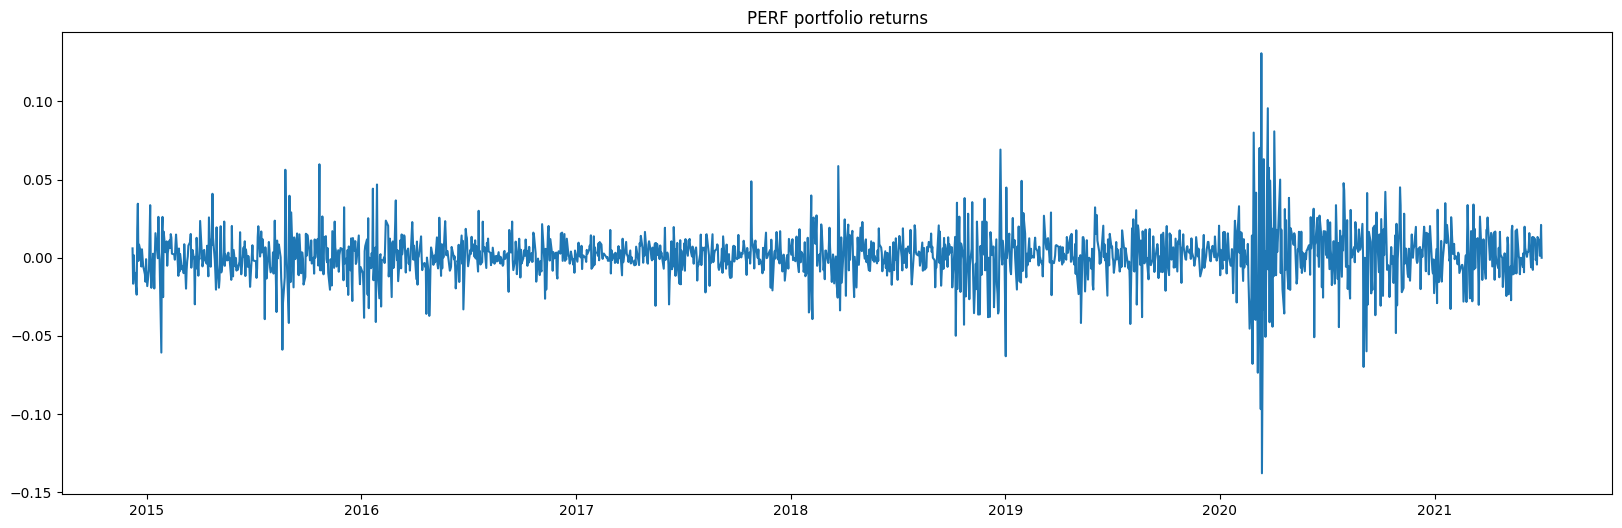

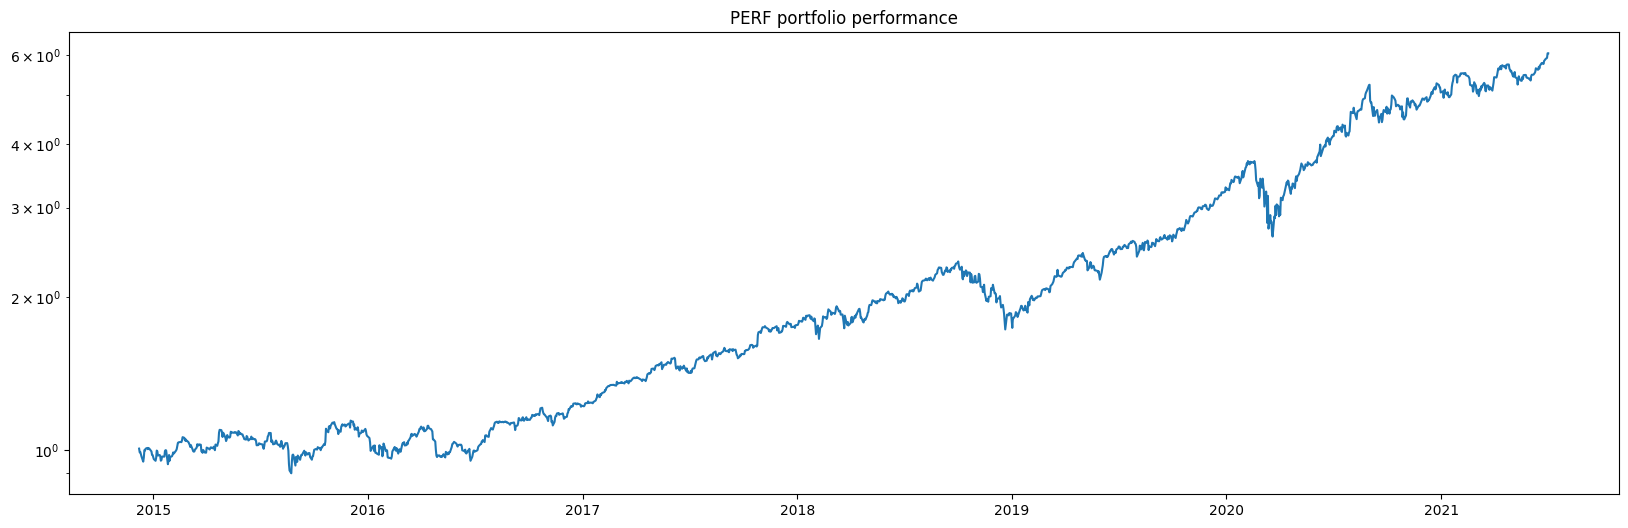

In [11]:
ukupno_perf = [1]
povrat_perf = []

#za svaki mjesec se pomicemo i racunamo volatility u intervalu godinu dana
for i in range(start, end, 21):
    volatility = {}
    for stock in selected_stocks:
        window_returns = returns_df[stock][i:i + 21]
        volatility[stock] = window_returns.std()

        observed_volatility[stock].append(volatility[stock])
    
    #racunamo tezine s obzirom na volatility
    weights = get_portf_weights(volatility) # 1/len(volatility)
    #za svaki dan racunamo promjenu u portfelju

    vector = weights
    sample_returns = np.dot(matrix[i:i+21], vector)
    for ret in sample_returns:
        povrat_perf.append(ret)
        ukupno_perf.append((ret+1)*ukupno_perf[-1])

print(ukupno_perf[-1])

plt.figure(figsize=(20, 6))
plt.plot(dates, povrat_perf)
plt.title("PERF portfolio returns")
plt.show()

plt.figure(figsize=(20, 6))
plt.semilogy(dates, ukupno_perf[1:])
plt.title("PERF portfolio performance")
plt.show()

6.200256751967546


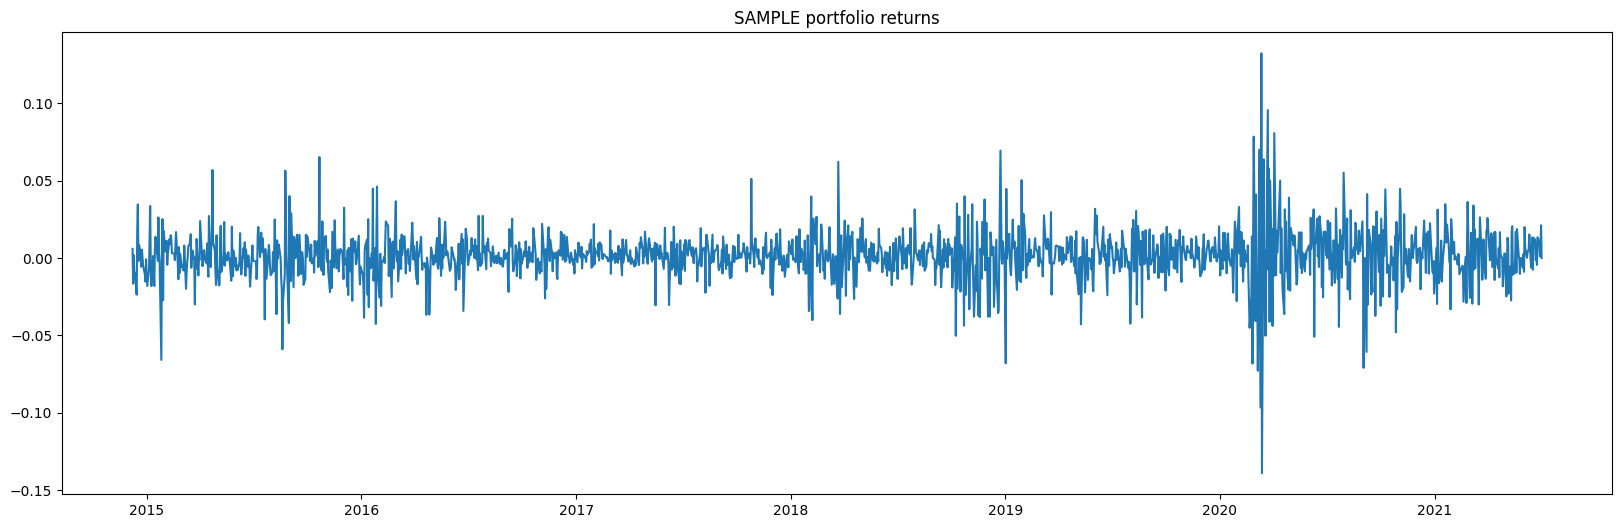

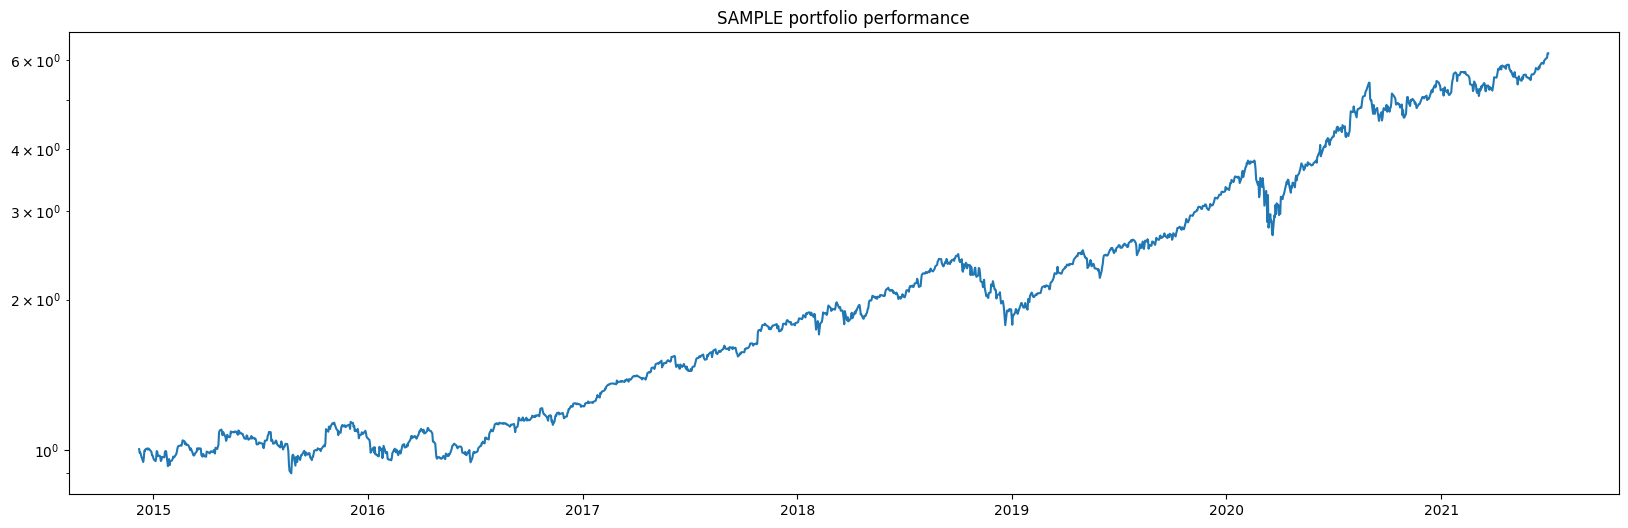

In [12]:
ukupno_sample = [1]
povrat_sample = []

#za svaki mjesec se pomicemo i racunamo volatility u intervalu godinu dana
for i in range(start, end, 21):
    volatility = {}
    for stock in selected_stocks:
        volatility[stock] = returns_df[stock][i - window: i].std()

        predicted_smp_volatility[stock].append(volatility[stock])
    
    #racunamo tezine s obzirom na volatility
    weights = get_portf_weights(volatility) # 1/len(volatility)
    #za svaki dan racunamo promjenu u portfelju

    vector = weights
    sample_returns = np.dot(matrix[i:i+21], vector)
    for ret in sample_returns:
        povrat_sample.append(ret)
        ukupno_sample.append((ret+1)*ukupno_sample[-1])

print(ukupno_sample[-1])

plt.figure(figsize=(20, 6))
plt.plot(dates, povrat_sample)
plt.title("SAMPLE portfolio returns")
plt.show()

plt.figure(figsize=(20, 6))
plt.semilogy(dates, ukupno_sample[1:])
plt.title("SAMPLE portfolio performance")
plt.show()

6.244918464917072


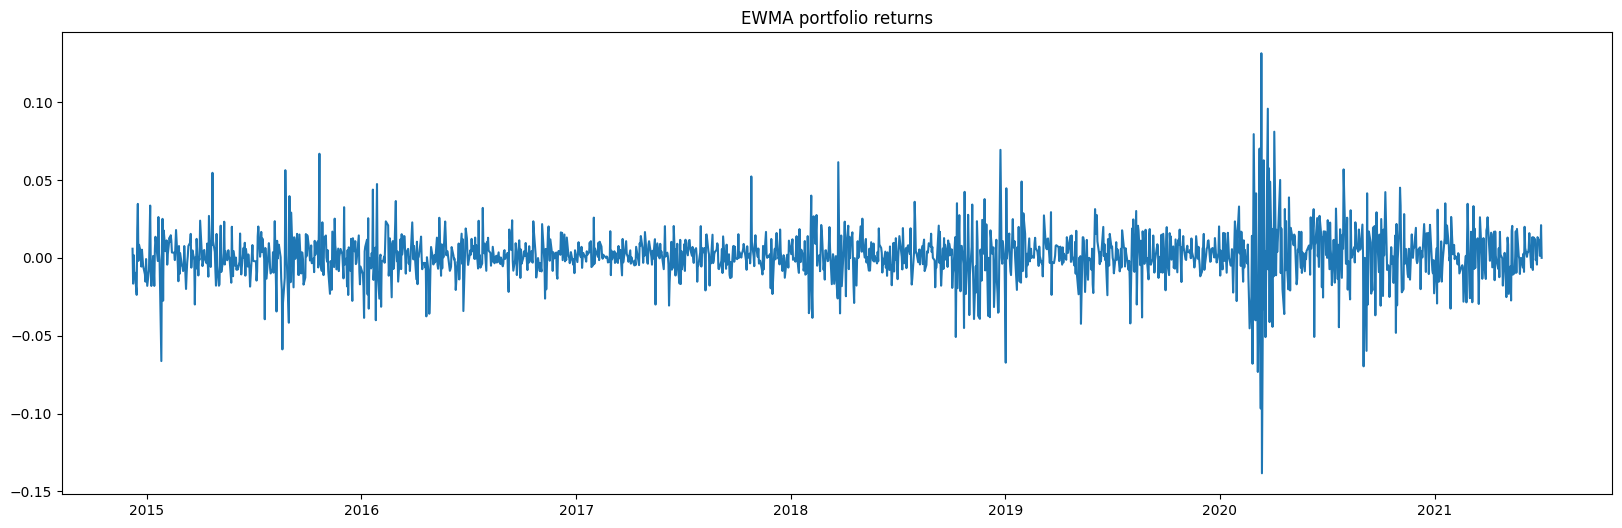

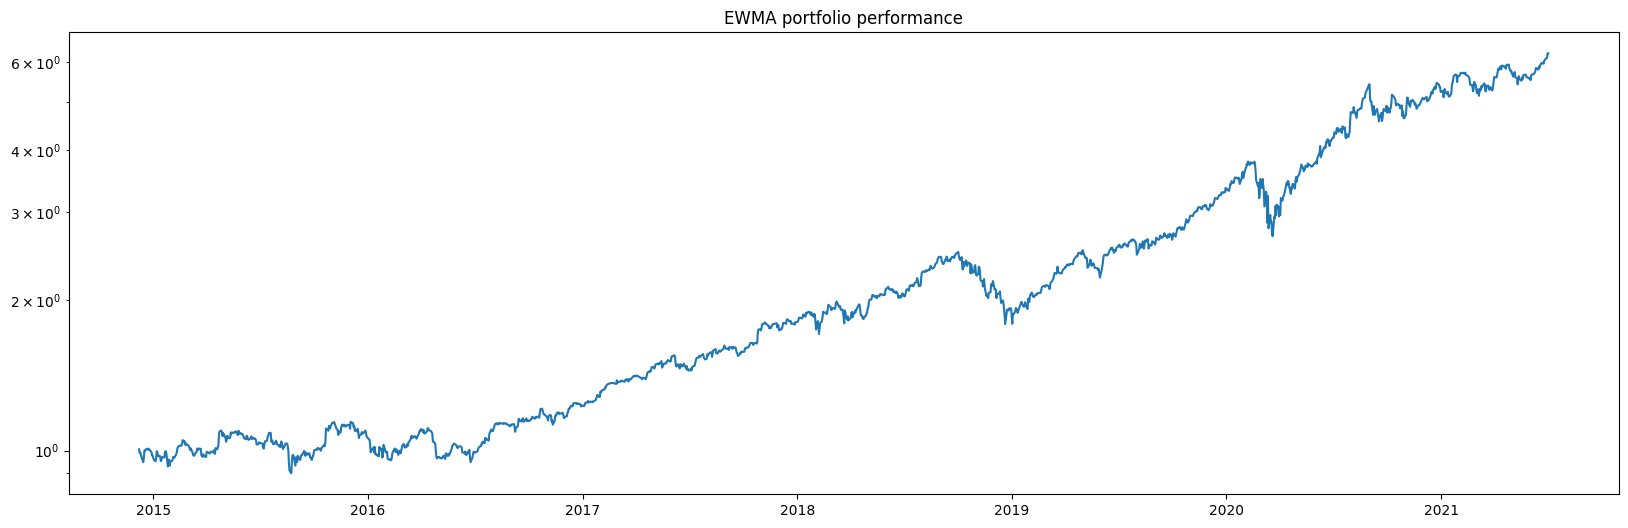

In [13]:
ukupno_ewma = [1]
povrat_ewma = []
def get_exp_weights(size, const=0.94):

    weights = [const**i for i in range(size, 0, -1)]
    suma = sum(weights)
    weights = [weight / suma for weight in weights]

    return weights


def ewma (weights, returns):
    variance = sum(weights * returns**2)
    return variance**0.5

#za svaki mjesec se pomicemo i racunamo volatility u intervalu godinu dana
for i in range(start, end, 21):
    weights = get_exp_weights(window)
    volatility = {}
    for stock in selected_stocks:
        window_returns = returns_df[stock][i - window: i]
        volatility[stock] = ewma(weights, window_returns)

        predicted_ewma_volatility[stock].append(volatility[stock])

    
    #racunamo tezine s obzirom na volatility
    weights = get_portf_weights(volatility) # 1/len(volatility)
    #za svaki dan racunamo promjenu u portfelju
    

    vector = weights
    ewma_returns = np.dot(matrix[i:i+21], vector)
    for ret in ewma_returns:
        povrat_ewma.append(ret)
        ukupno_ewma.append((ret+1)*ukupno_ewma[-1])

print(ukupno_ewma[-1])

plt.figure(figsize=(20, 6))
plt.plot(dates, povrat_ewma)
plt.title("EWMA portfolio returns")
plt.show()

plt.figure(figsize=(20, 6))
plt.semilogy(dates, ukupno_ewma[1:])
plt.title("EWMA portfolio performance")
plt.show()

In [14]:
regr_window = 21

def get_lstsq_betas(end):
    A = []
    B = []

    for i in range(0, end - regr_window - 21, 21):
        for stock in selected_stocks:
            A.append(returns_df[stock][i:i + regr_window] ** 2)
            B.append(returns_df[stock][i + regr_window:i + regr_window + 21].var())

    A = np.array(A)  # Convert list of arrays to a single 2D array
    B = np.array(B)  # Convert list of arrays to a single 2D array
    
    X = LinearRegression(positive=True, fit_intercept=False)
    X.fit(A, B)

    return X

X = get_lstsq_betas(start)

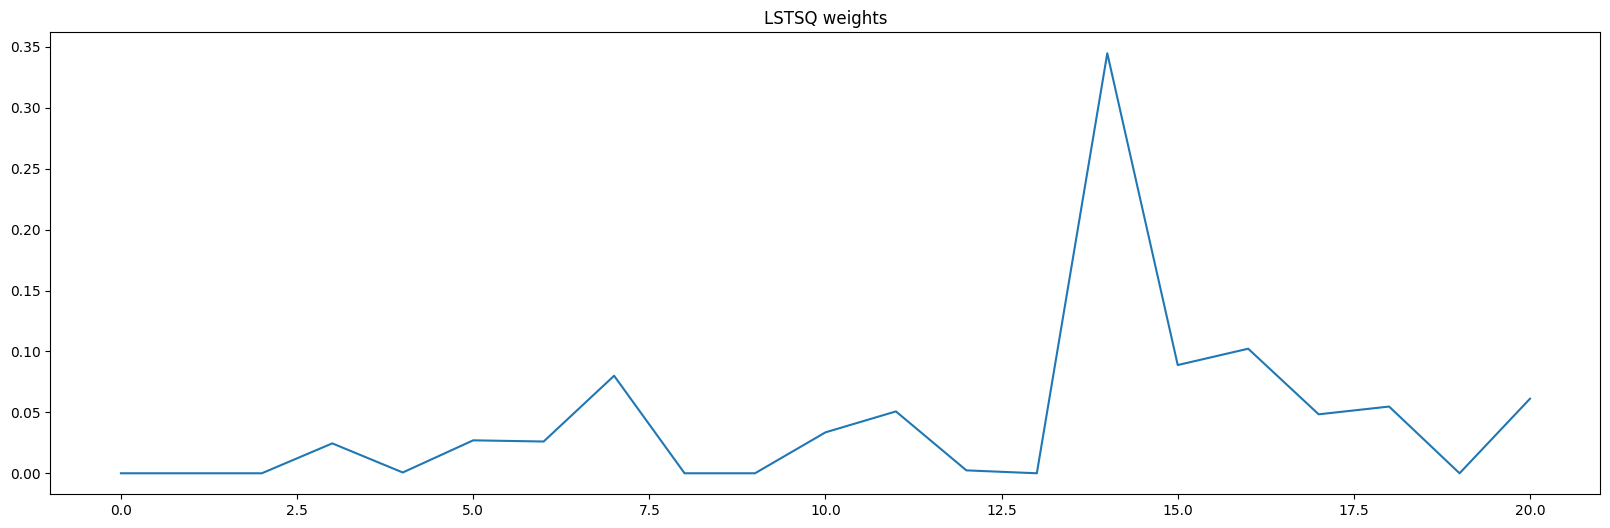

In [15]:
plt.figure(figsize=(20, 6))
plt.plot(X.coef_)
plt.title("LSTSQ weights")
plt.show()

6.340642525522073


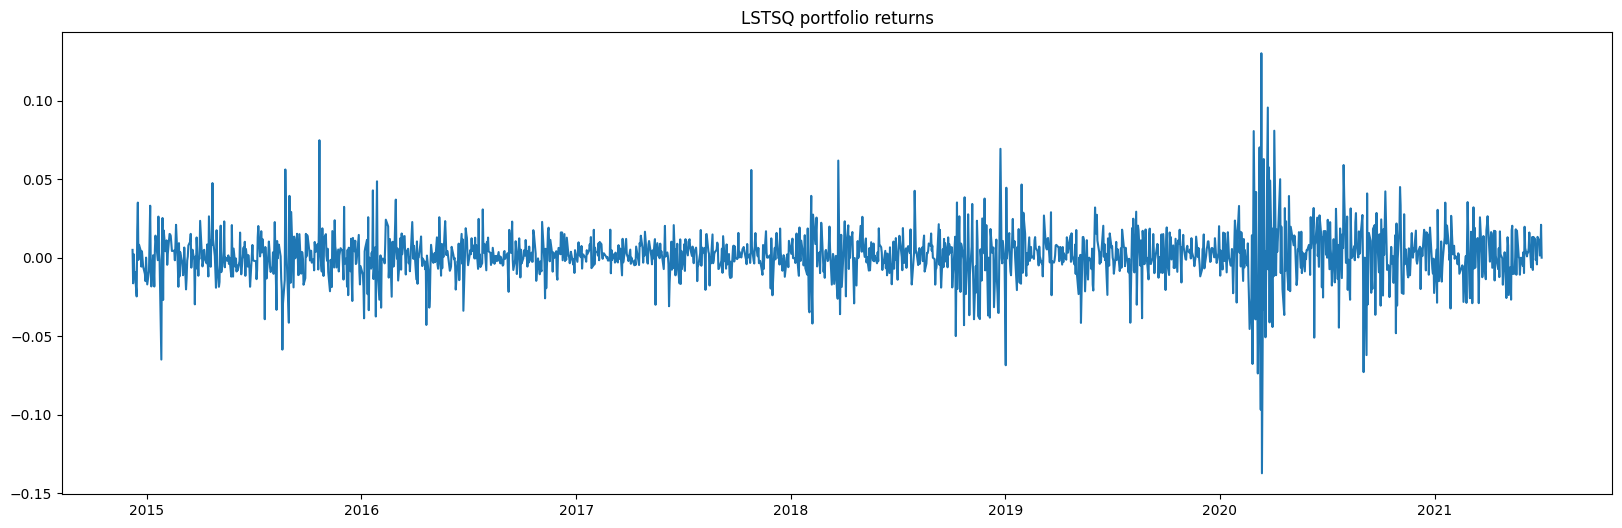

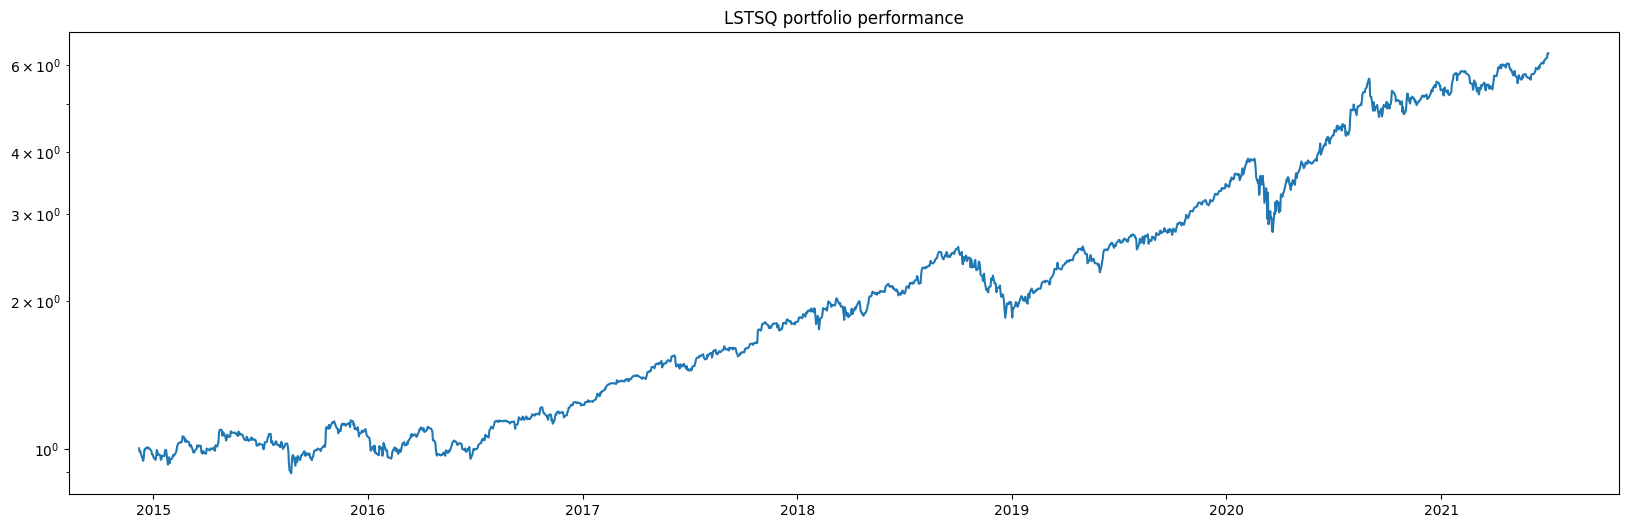

In [16]:
ukupno_lstsq = [1]
povrat_lstsq = []

predicted_lsq_volatility.clear()

#za svaki mjesec se pomicemo i racunamo volatility u intervalu godinu dana
for i in range(start, end, 21):
    volatility = {}
    for stock in selected_stocks:
        window_returns = returns_df[stock][i-regr_window:i].values.reshape(1, -1)
        volatility[stock] = X.predict(window_returns**2) ** 0.5
 
        predicted_lsq_volatility[stock].append(volatility[stock])

    
    #racunamo tezine s obzirom na volatility
    weights = get_portf_weights(volatility) # 1/len(volatility)
    #za svaki dan racunamo promjenu u portfelju
    

    vector = weights
    lstsq_returns = np.dot(matrix[i:i+21], vector)
    for ret in lstsq_returns:
        povrat_lstsq.append(ret)
        ukupno_lstsq.append((ret+1)*ukupno_lstsq[-1])

print(ukupno_lstsq[-1])

plt.figure(figsize=(20, 6))
plt.plot(dates, povrat_lstsq)
plt.title("LSTSQ portfolio returns")
plt.show()

plt.figure(figsize=(20, 6))
plt.semilogy(dates, ukupno_lstsq[1:])
plt.title("LSTSQ portfolio performance")
plt.show()

In [17]:
def get_lstsq_stock_betas(stock, end):
    A = []  # Initialize empty list for A
    B = []  # Initialize empty list for B

    for i in range(0, end - regr_window - 21, 21):
        A.append(returns_df[stock][i:i + regr_window] ** 2)
        B.append(returns_df[stock][i + regr_window:i + regr_window + 21].var())

    A = np.array(A)  # Convert list of arrays to a single 2D array
    B = np.array(B)  # Convert list of arrays to a single 2D array
    
    X = LinearRegression(positive=True, fit_intercept=False)
    X.fit(A, B)

    return X

X = {}
for stock in selected_stocks:
    X[stock] = get_lstsq_stock_betas(stock, start)

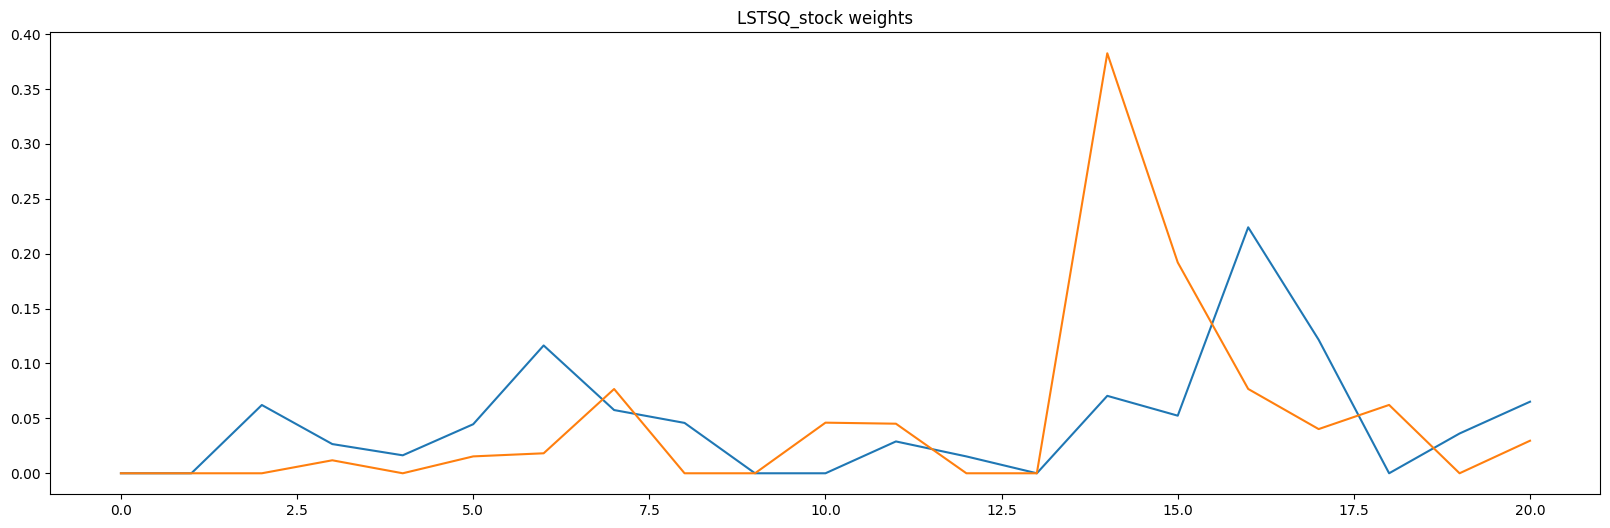

In [18]:
plt.figure(figsize=(20, 6))
for stock in selected_stocks:
    if not any(coef > 1 for coef in X[stock].coef_): 
        plt.plot(X[stock].coef_)
plt.title("LSTSQ_stock weights")
plt.show()

5.956310750376204


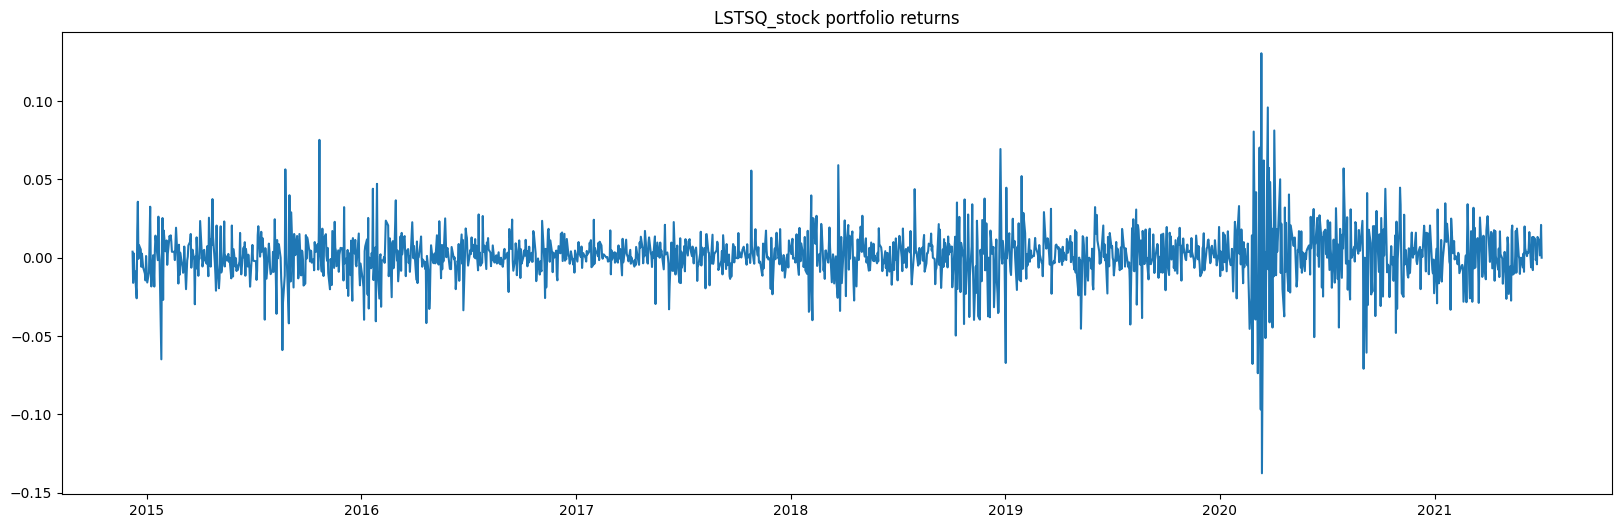

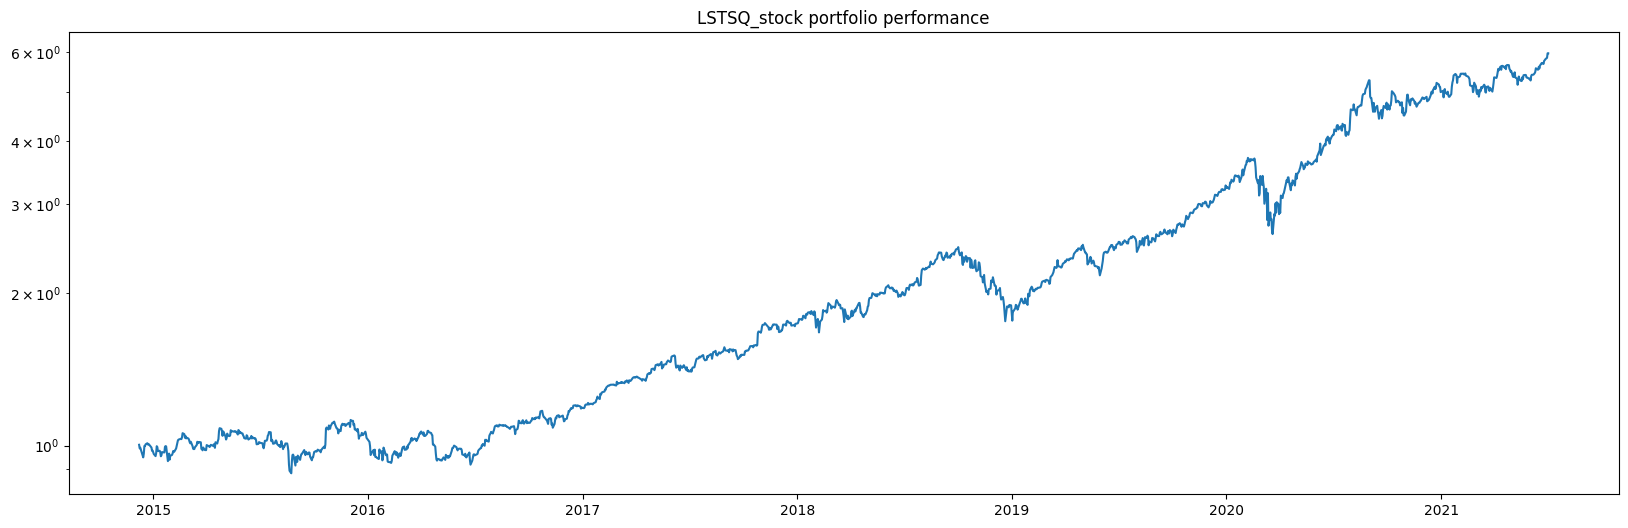

In [19]:
ukupno_lstsq_stock = [1]
povrat_lstsq_stock = []

predicted_lsq_stock_volatility.clear()

#za svaki mjesec se pomicemo i racunamo volatilnost u intervalu godinu dana
for i in range(start, end, 21):
    volatility = {}
    for stock in selected_stocks:
        window_returns = (returns_df[stock][i - regr_window:i]).values.reshape(1, -1)
        volatility[stock] = X[stock].predict(window_returns**2) ** 0.5

        predicted_lsq_stock_volatility[stock].append(volatility[stock])
    
    #racunamo tezine s obzirom na volatilnost
    weights = get_portf_weights(volatility) # 1/len(volatilnost)
    #za svaki dan racunamo promjenu u portfelju
    

    vector = weights
    lstsq_stock_returns = np.dot(matrix[i:i+21], vector)
    for ret in lstsq_stock_returns:
        povrat_lstsq_stock.append(ret)
        ukupno_lstsq_stock.append((ret+1)*ukupno_lstsq_stock[-1])

print(ukupno_lstsq_stock[-1])

plt.figure(figsize=(20, 6))
plt.plot(dates, povrat_lstsq_stock)
plt.title("LSTSQ_stock portfolio returns")
plt.show()

plt.figure(figsize=(20, 6))
plt.semilogy(dates, ukupno_lstsq_stock[1:])
plt.title("LSTSQ_stock portfolio performance")
plt.show()

In [20]:
regr_window = 21

def log_regr(end):
    A = []
    B = []

    for i in range(0, end - regr_window - 21, 21):
        for stock in selected_stocks:
            b = returns_df[stock][i + regr_window:i + regr_window + 21].var()
            if b != 0:
                A.append(np.log(1+returns_df[stock][i:i + regr_window]))
                B.append(np.log(b))

    A = np.array(A)  # Convert list of arrays to a single 2D array
    B = np.array(B)  # Convert list of arrays to a single 2D array
    
    X = LinearRegression()
    X.fit(A, B)

    return X

X = log_regr(start)

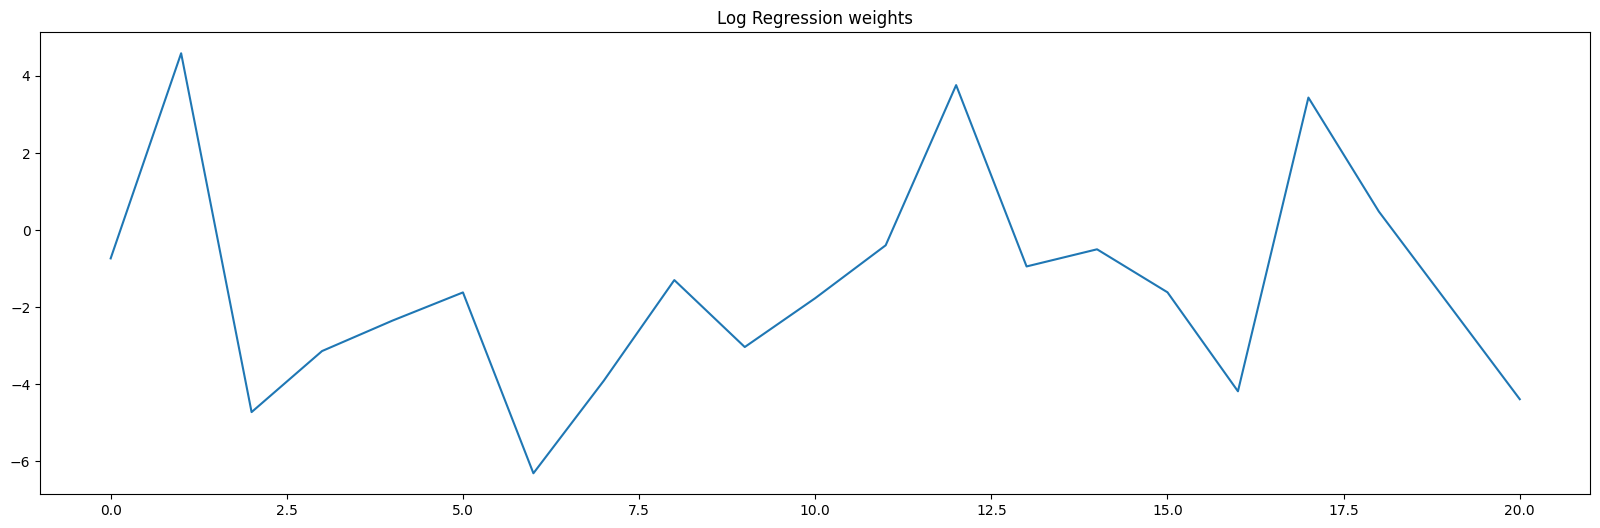

In [21]:
plt.figure(figsize=(20, 6))
plt.plot(X.coef_)
plt.title("Log Regression weights")
plt.show()

6.2522230259057565


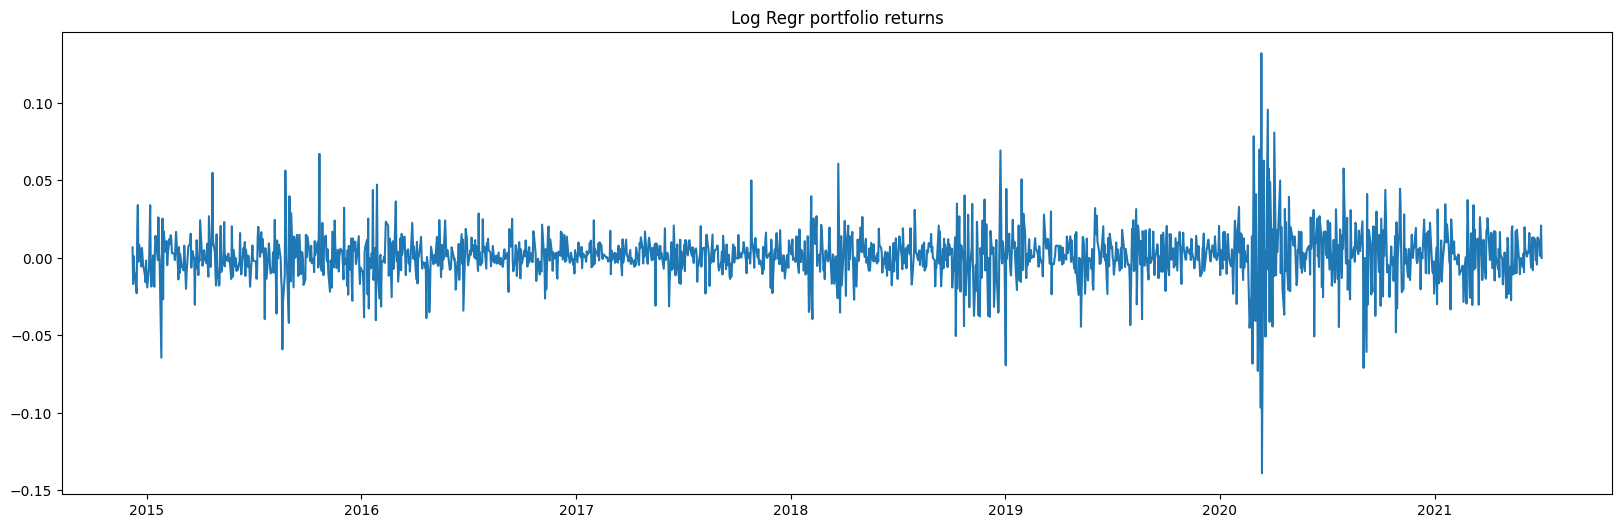

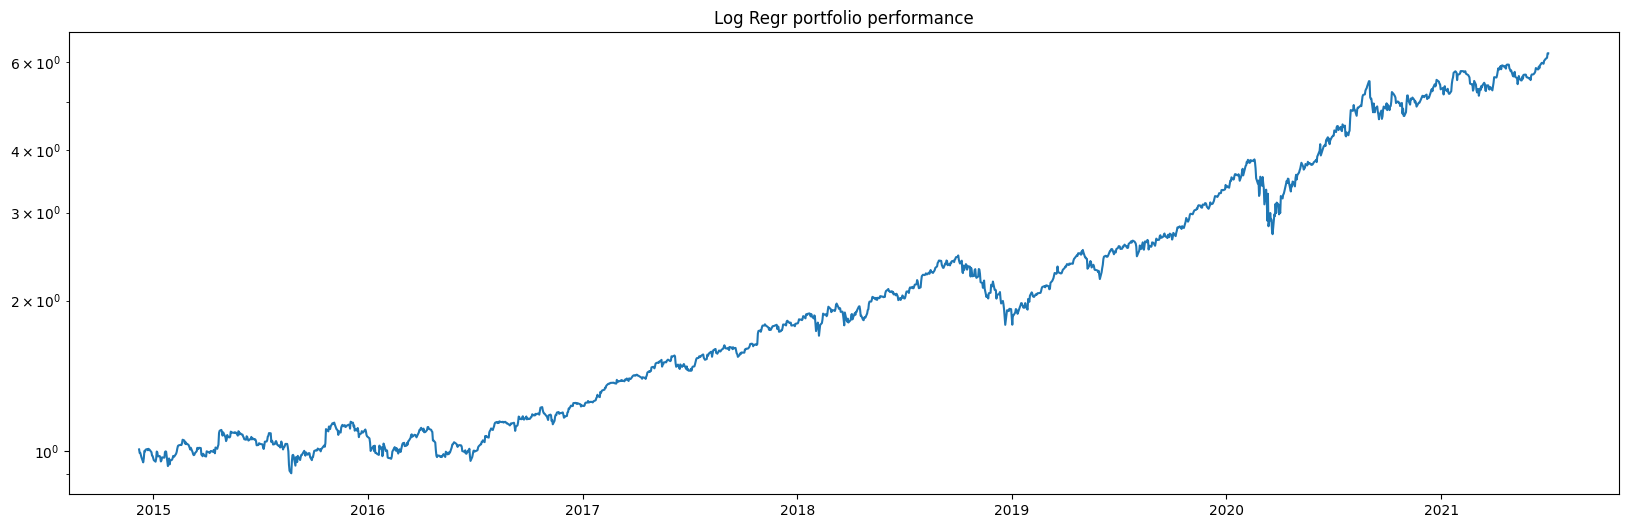

In [22]:
ukupno_logregr = [1]
povrat_logregr = []

predicted_logregr_volatility.clear()

#za svaki mjesec se pomicemo i racunamo volatility u intervalu godinu dana
for i in range(start, end, 21):
    volatility = {}
    for stock in selected_stocks:
        window_returns = returns_df[stock][i-regr_window:i].values.reshape(1, -1)
        volatility[stock] = np.exp(X.predict(np.log(1+window_returns))) ** 0.5
 
        predicted_logregr_volatility[stock].append(volatility[stock])

    
    #racunamo tezine s obzirom na volatility
    weights = get_portf_weights(volatility) # 1/len(volatility)
    #za svaki dan racunamo promjenu u portfelju
    

    vector = weights
    logregr_returns = np.dot(matrix[i:i+21], vector)
    for ret in logregr_returns:
        povrat_logregr.append(ret)
        ukupno_logregr.append((ret+1)*ukupno_logregr[-1])

print(ukupno_logregr[-1])

plt.figure(figsize=(20, 6))
plt.plot(dates, povrat_logregr)
plt.title("Log Regr portfolio returns")
plt.show()

plt.figure(figsize=(20, 6))
plt.semilogy(dates, ukupno_logregr[1:])
plt.title("Log Regr portfolio performance")
plt.show()

In [23]:
def logregr_stock(stock, end):
    A = []  # Initialize empty list for A
    B = []  # Initialize empty list for B

    for i in range(0, end - regr_window - 21, 21):
        b = returns_df[stock][i + regr_window:i + regr_window + 21].var()
        if b != 0:
            A.append(np.log(1+returns_df[stock][i:i + regr_window]))
            B.append(np.log(b))

    A = np.array(A)  # Convert list of arrays to a single 2D array
    B = np.array(B)  # Convert list of arrays to a single 2D array
    
    X = LinearRegression()
    X.fit(A, B)

    return X

X = {}
for stock in selected_stocks:
    X[stock] = logregr_stock(stock, start)

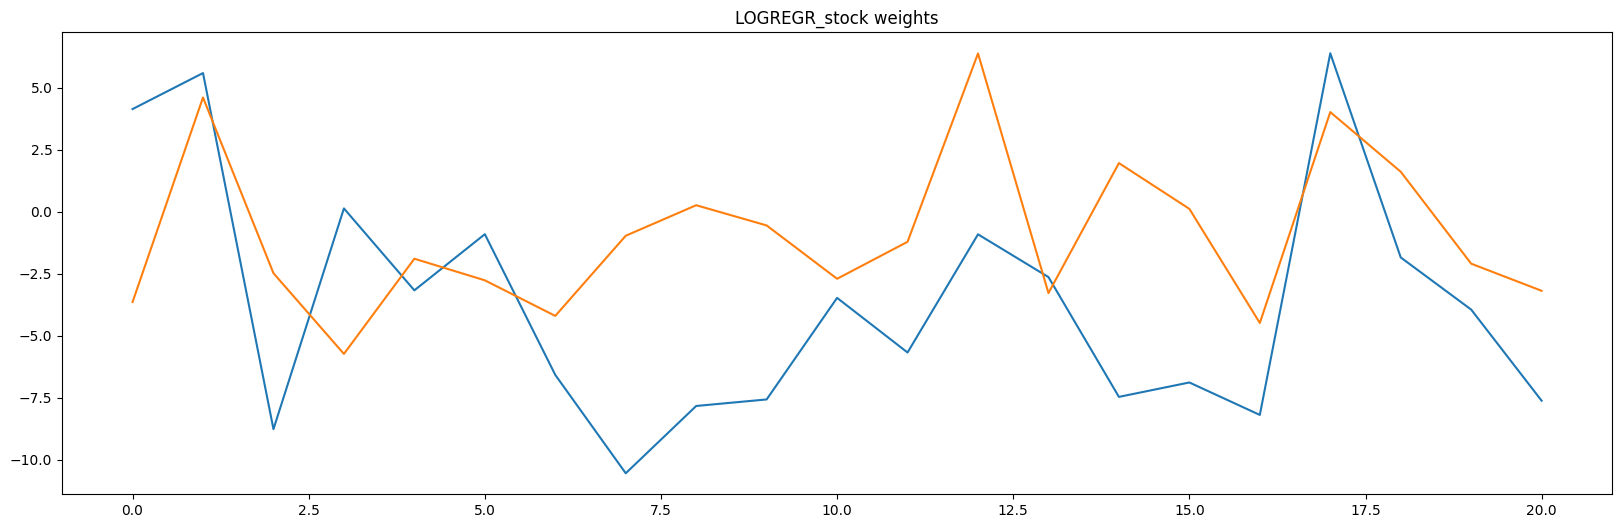

In [24]:
plt.figure(figsize=(20, 6))
for stock in selected_stocks:
    plt.plot(X[stock].coef_)
plt.title("LOGREGR_stock weights")
plt.show()

6.106663517059571
1680


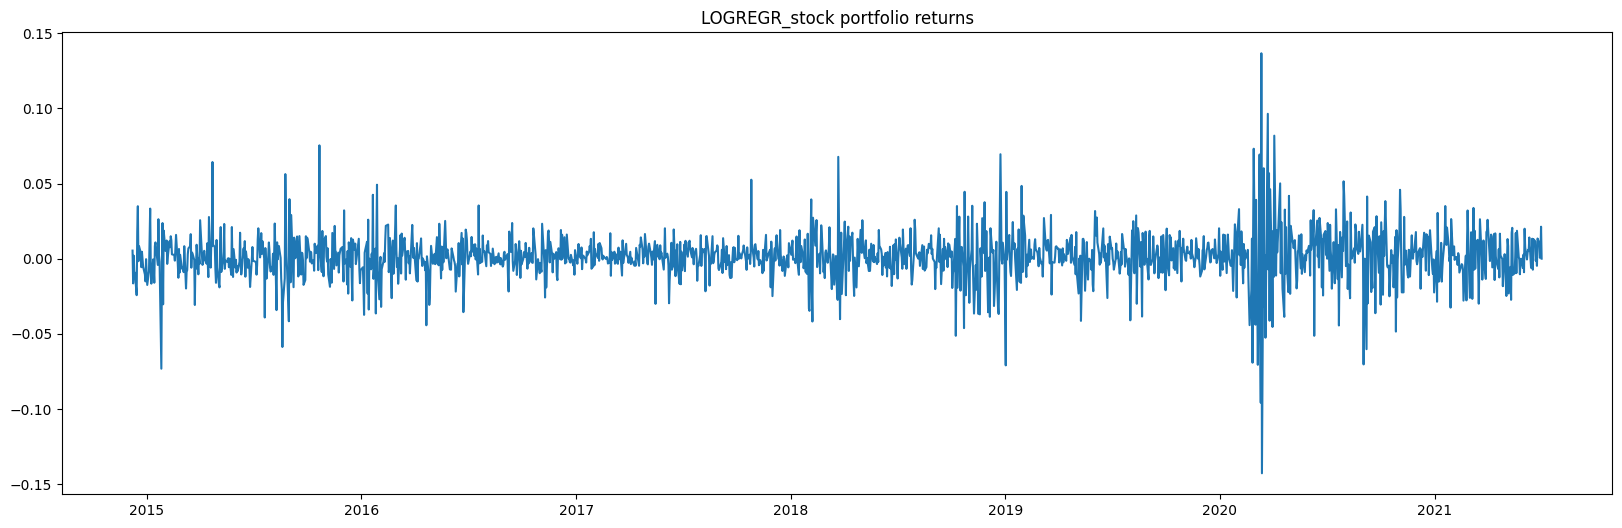

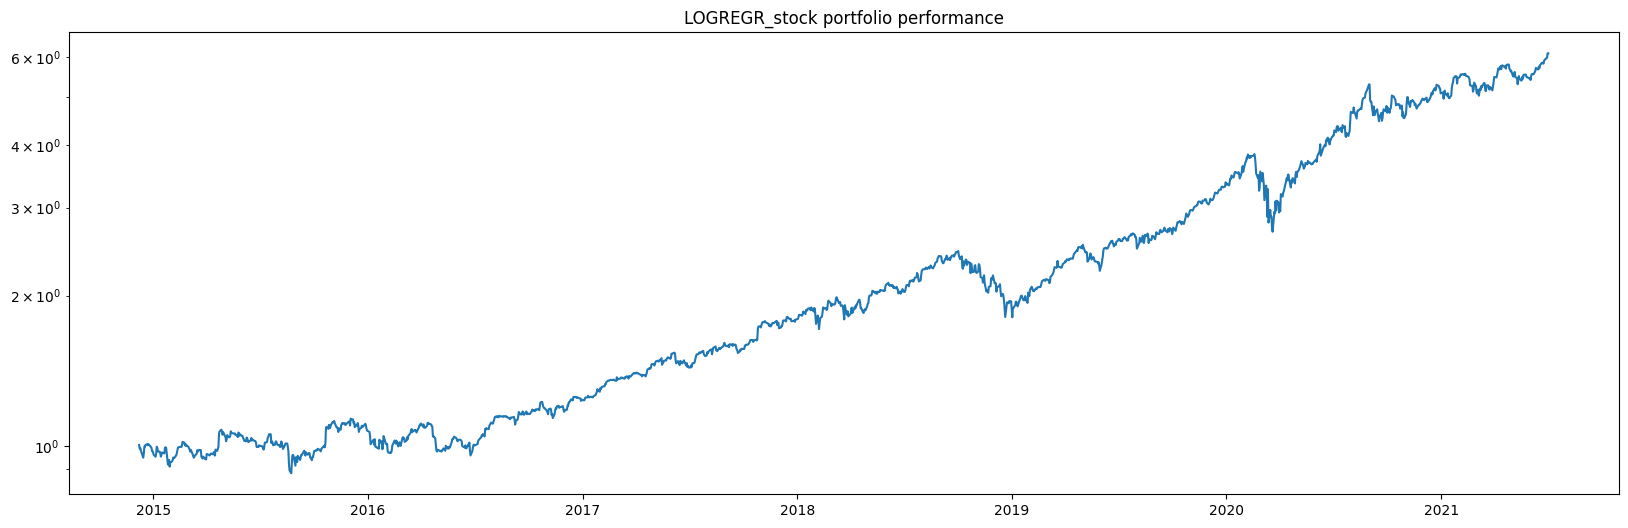

In [25]:
ukupno_logregr_stock = [1]
povrat_logregr_stock = []

predicted_logregr_stock_volatility.clear()

#za svaki mjesec se pomicemo i racunamo volatilnost u intervalu godinu dana
for i in range(start, end, 21):
    volatility = {}
    for stock in selected_stocks:
        window_returns = (returns_df[stock][i - regr_window:i]).values.reshape(1, -1)
        volatility[stock] = np.exp(X[stock].predict(np.log(1+window_returns))) ** 0.5

        predicted_logregr_stock_volatility[stock].append(volatility[stock])
    
    #racunamo tezine s obzirom na volatilnost
    weights = get_portf_weights(volatility) # 1/len(volatilnost)
    #za svaki dan racunamo promjenu u portfelju
    

    vector = weights
    logregr_stock_returns = np.dot(matrix[i:i+21], vector)
    for ret in logregr_stock_returns:
        povrat_logregr_stock.append(ret)
        ukupno_logregr_stock.append((ret+1)*ukupno_logregr_stock[-1])

print(ukupno_logregr_stock[-1])
print(len(povrat_logregr_stock))
plt.figure(figsize=(20, 6))
plt.plot(dates, povrat_logregr_stock)
plt.title("LOGREGR_stock portfolio returns")
plt.show()

plt.figure(figsize=(20, 6))
plt.semilogy(dates, ukupno_logregr_stock[1:])
plt.title("LOGREGR_stock portfolio performance")
plt.show()

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# rf_window = 21

# features = []
# next_month_volatility = []

# for i in range(start - rf_window*2):
#         for stock in selected_stocks:
#             features.append(returns_df[stock][i : i + rf_window])
#             next_month_volatility.append(returns_df[stock][i + rf_window : i + rf_window*2].std())

# # Razdvajanje podataka na skupove za treniranje i testiranje
# X_train, X_test, y_train, y_test = train_test_split(features, next_month_volatility, test_size=0.1, random_state=42)

# # Inicijalizacija i treniranje Random Forest regresijskog modela
# random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
# random_forest.fit(X_train, y_train)

# # Predviđanje volatilnosti sljedećeg mjeseca
# predicted_volatility = random_forest.predict(X_test)

# # Evaluacija modela
# rf_mse = mean_squared_error(y_test, predicted_volatility)


In [27]:
# ukupno_rf = [1]
# povrat_rf = []



# #za svaki mjesec se pomicemo i racunamo volatilnost u intervalu godinu dana
# for i in range(start, end - 9, 21):
#     volatility = {}
#     for stock in selected_stocks:
#         window_returns = returns_df[stock][i - rf_window:i]
#         window_returns = window_returns[::-1]
#         volatility[stock] = random_forest.predict(np.array(window_returns).reshape(1, -1))
    
#     #racunamo tezine s obzirom na volatilnost
#     weights = get_portf_weights(volatility) # 1/len(volatilnost)
#     #za svaki dan racunamo promjenu u portfelju
    

#     vector = weights
#     rf_returns = np.dot(matrix[i:i+rf_window], vector)
#     for ret in rf_returns:
#         povrat_rf.append(ret)
#         ukupno_rf.append((ret+1)*ukupno_rf[-1])

# #ukupno_rf = [item if isinstance(item, (int, float)) else item[0] for item in ukupno_rf]
# print(ukupno_rf[-1])
# print(len(povrat_rf))

# plt.figure(figsize=(20, 6))
# plt.plot(povrat_rf)
# plt.title("Random forrest portfolio returns")
# #plt.xticks(np.arange(0, len(povrat_sample), 252), np.arange(2001, 2022, 1))
# plt.show()

# plt.figure(figsize=(20, 6))
# plt.semilogy([item if isinstance(item, (int, float)) else item[0] for item in ukupno_rf])
# plt.title("Random forrest portfolio performance")
# #plt.xticks(np.arange(0, len(ukupno_sample), 252), np.arange(2001, 2022, 1))
# plt.show()

In [28]:
def get_mse(predicted_volatility, observed_volatility):
    #polje za mse svake dionice
    mse = []
    for stock_symbol in selected_stocks:
        mse.append(mean_squared_error(predicted_volatility[stock_symbol], observed_volatility[stock_symbol]))
    return np.mean(mse)

In [29]:
portfolio_df = [["Estimators (T = " + str(window) + " Trading Days)", "Standard Deviation", "Average Return", "Sharpe Ratio", 'Mean Squared Error']]

eq_portfolio = ["Equal Weight Portfolio"]

povrat_eq_df = pd.DataFrame(povrat_eq)

eq_std = povrat_eq_df.std() * 252**0.5
eq_return = (1 + povrat_eq_df.mean())**252 - 1
eq_sharpe = eq_return[0] / eq_std[0]

eq_portfolio.append(eq_std[0])
eq_portfolio.append(eq_return[0])
eq_portfolio.append(eq_sharpe)
portfolio_df.append(eq_portfolio)

perf_portfolio = ["Perfect Prediction Portfolio"]

povrat_perf_df = pd.DataFrame(povrat_perf)

perf_std = povrat_perf_df.std() * 252**0.5
perf_return = (1 + povrat_perf_df.mean())**252 - 1
perf_sharpe = perf_return[0] / perf_std[0]

perf_portfolio.append(perf_std[0])
perf_portfolio.append(perf_return[0])
perf_portfolio.append(perf_sharpe)
perf_portfolio.append(get_mse(observed_volatility, observed_volatility))
portfolio_df.append(perf_portfolio)

sample_portfolio = ["Sample Portfolio"]

povrat_sample_df = pd.DataFrame(povrat_sample)

sample_std = povrat_sample_df.std() * 252**0.5
sample_return = (1 + povrat_sample_df.mean())**252 - 1
sample_sharpe = sample_return[0] / sample_std[0]

sample_portfolio.append(sample_std[0])
sample_portfolio.append(sample_return[0])
sample_portfolio.append(sample_sharpe)
sample_portfolio.append(get_mse(predicted_smp_volatility, observed_volatility))
portfolio_df.append(sample_portfolio)


ewma_portfolio = ["Exponentially Weighted Returns Portfolio"]

povrat_ewma_df = pd.DataFrame(povrat_ewma)

ewma_std = povrat_ewma_df.std() * 252**0.5
ewma_return = (1 + povrat_ewma_df.mean())**252 - 1
ewma_sharpe = ewma_return[0] / ewma_std[0]
ewma_portfolio.append(ewma_std[0])
ewma_portfolio.append(ewma_return[0])
ewma_portfolio.append(ewma_sharpe)
ewma_portfolio.append(get_mse(predicted_ewma_volatility, observed_volatility))
portfolio_df.append(ewma_portfolio)


lstsq_portfolio = ["Least-Squares Portfolio " + str(regr_window)]

povrat_lstsq_df = pd.DataFrame(povrat_lstsq)

lstsq_std = povrat_lstsq_df.std() * 252**0.5
lstsq_return = (1 + povrat_lstsq_df.mean())**252 - 1
lstsq_sharpe = lstsq_return[0] / lstsq_std[0]

lstsq_portfolio.append(lstsq_std[0])
lstsq_portfolio.append(lstsq_return[0])
lstsq_portfolio.append(lstsq_sharpe)
lstsq_portfolio.append(get_mse(predicted_lsq_volatility, observed_volatility))
portfolio_df.append(lstsq_portfolio)


lstsq_stock_portfolio = ["Least-Squares (Stock) Portfolio " + str(regr_window)]

povrat_lstsq_stock_df = pd.DataFrame(povrat_lstsq_stock)

lstsq_stock_std = povrat_lstsq_stock_df.std() * 252**0.5
lstsq_stock_return = (1 + povrat_lstsq_stock_df.mean())**252 - 1
lstsq_stock_sharpe = lstsq_stock_return[0] / lstsq_stock_std[0]

lstsq_stock_portfolio.append(lstsq_stock_std[0])
lstsq_stock_portfolio.append(lstsq_stock_return[0])
lstsq_stock_portfolio.append(lstsq_stock_sharpe)
lstsq_stock_portfolio.append(get_mse(predicted_lsq_stock_volatility, observed_volatility))
portfolio_df.append(lstsq_stock_portfolio)


logregr_portfolio = ["Log Regr Portfolio " + str(regr_window)]

povrat_logregr_df = pd.DataFrame(povrat_logregr)

logregr_std = povrat_logregr_df.std() * 252**0.5
logregr_return = (1 + povrat_logregr_df.mean())**252 - 1
logregr_sharpe = logregr_return[0] / logregr_std[0]

logregr_portfolio.append(logregr_std[0])
logregr_portfolio.append(logregr_return[0])
logregr_portfolio.append(logregr_sharpe)
logregr_portfolio.append(get_mse(predicted_logregr_volatility, observed_volatility))
portfolio_df.append(logregr_portfolio)


logregr_stock_portfolio = ["Log Regr (Stock) Portfolio " + str(regr_window)]

povrat_logregr_stock_df = pd.DataFrame(povrat_logregr_stock)

logregr_stock_std = povrat_logregr_stock_df.std() * 252**0.5
logregr_stock_return = (1 + povrat_logregr_stock_df.mean())**252 - 1
logregr_stock_sharpe = logregr_stock_return[0] / logregr_stock_std[0]

logregr_stock_portfolio.append(logregr_stock_std[0])
logregr_stock_portfolio.append(logregr_stock_return[0])
logregr_stock_portfolio.append(logregr_stock_sharpe)
logregr_stock_portfolio.append(get_mse(predicted_logregr_stock_volatility, observed_volatility))
portfolio_df.append(logregr_stock_portfolio)


# random_forest_portfolio = ["Rand Forr Portfolio " + str(rf_window)]

# random_forest_df = pd.DataFrame(povrat_rf)

# rf_std = random_forest_df.std() * 252**0.5
# rf_return = (1 + random_forest_df.mean())**252 - 1
# rf_sharpe = rf_return[0] / rf_std[0]

# random_forest_portfolio.append(rf_std[0])
# random_forest_portfolio.append(rf_return[0])
# random_forest_portfolio.append(rf_sharpe)
# random_forest_portfolio.append(rf_mse)
# portfolio_df.append(random_forest_portfolio)


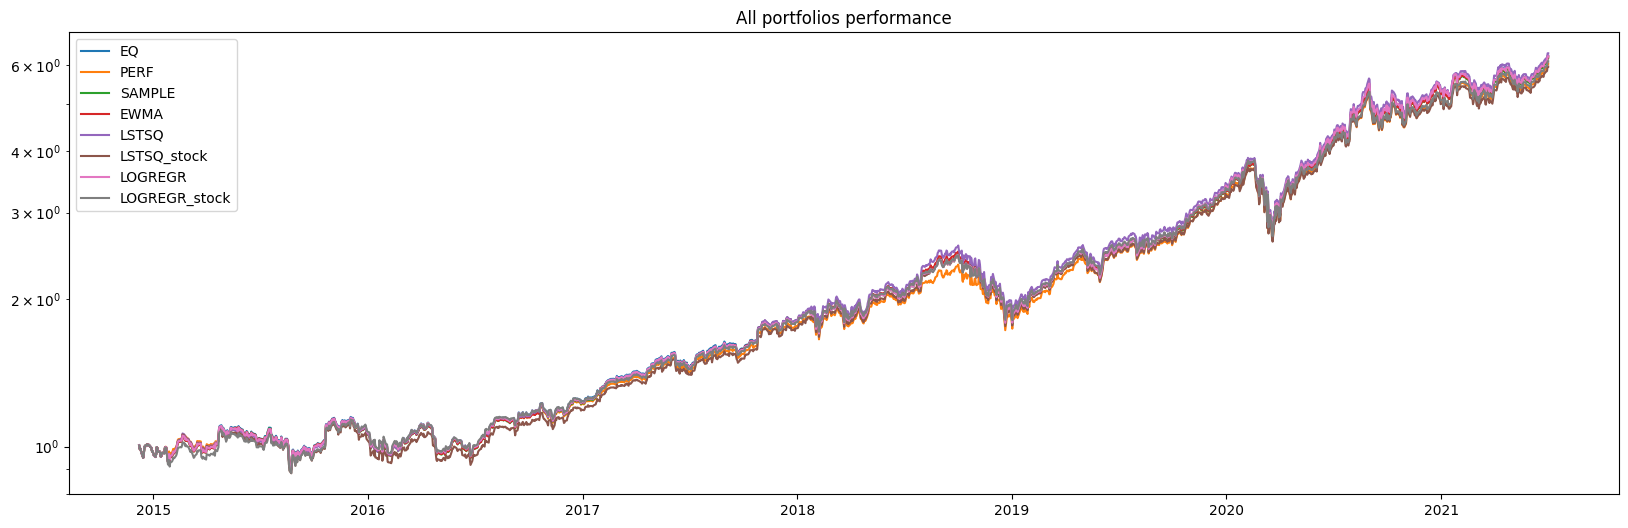

In [30]:
plt.figure(figsize=(20, 6))
plt.semilogy(dates, ukupno_eq[1:], label='EQ')
plt.semilogy(dates, ukupno_perf[1:], label='PERF')
plt.semilogy(dates, ukupno_sample[1:], label='SAMPLE')
plt.semilogy(dates, ukupno_ewma[1:], label='EWMA')
plt.semilogy(dates, ukupno_lstsq[1:], label='LSTSQ')
plt.semilogy(dates, ukupno_lstsq_stock[1:], label='LSTSQ_stock')
plt.semilogy(dates, ukupno_logregr[1:], label='LOGREGR')
plt.semilogy(dates, ukupno_logregr_stock[1:], label='LOGREGR_stock')
#plt.semilogy(dates, ukupno_rf[1:], label='RF')
plt.title("All portfolios performance")
plt.legend()
plt.show()

In [31]:
#obicni R

from sklearn.model_selection import KFold


features = []
next_month_volatility = []
rf_window = 21


for i in range(start - rf_window*2):
        for stock in selected_stocks:
            features.append(returns_df[stock][i : i + rf_window])
            next_month_volatility.append(np.log(returns_df[stock][i + rf_window : i + rf_window*2].var()))

# Razdvajanje podataka na skupove za treniranje i testiranje
X_train, X_test, y_train, y_test = train_test_split(features, next_month_volatility, test_size=0.2, random_state=42)

# Inicijalizacija i treniranje Random Forest regresijskog modela
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# K-fold unakrsna validacija
kf = KFold(n_splits=4, shuffle=True, random_state=42)  # 5-fold validacija, možete promijeniti broj foldova prema potrebi

mse_scores = []  # Lista za pohranu MSE vrijednosti za svaki fold

for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train)):
    X_train_fold = [X_train[i] for i in train_index]
    X_val_fold = [X_train[i] for i in test_index] 
    y_train_fold = [y_train[i] for i in train_index]
    y_val_fold = [y_train[i] for i in test_index]   
    # X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
    # y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]


    # Treniranje modela na trenirajućem skupu
    random_forest.fit(X_train_fold, y_train_fold)

    # Predviđanje volatilnosti na validacijskom skupu
    predicted_val_volatility = random_forest.predict(X_val_fold)

    # Računanje MSE za trenutni fold
    fold_mse = mean_squared_error(y_val_fold, predicted_val_volatility)
    mse_scores.append(fold_mse)

# Srednja vrijednost MSE za sve foldove
average_mse = sum(mse_scores) / len(mse_scores)

# Ispis srednje vrijednosti MSE
print(f"Srednja vrijednost MSE za {kf.n_splits}-fold unakrsnu validaciju: {average_mse}")

# Predviđanje volatilnosti sljedećeg mjeseca
predicted_volatility = random_forest.predict(X_test)

# Evaluacija modela
rf_mse = mean_squared_error(y_test, predicted_volatility)


ukupno_rf = [1]
povrat_rf = []



#za svaki mjesec se pomicemo i racunamo volatilnost u intervalu godinu dana
for i in range(start, end - 9, 21):
    volatility = {}
    for stock in selected_stocks:
        window_returns = returns_df[stock][i - rf_window:i]
        window_returns = window_returns[::-1]
        volatility[stock] = np.exp(random_forest.predict(np.array(window_returns).reshape(1, -1))) ** 0.5
    
    #racunamo tezine s obzirom na volatilnost
    weights = get_portf_weights(volatility) # 1/len(volatilnost)
    #za svaki dan racunamo promjenu u portfelju
    

    vector = weights
    rf_returns = np.dot(matrix[i:i+rf_window], vector)
    for ret in rf_returns:
        povrat_rf.append(ret)
        ukupno_rf.append((ret+1)*ukupno_rf[-1])

random_forest_portfolio = ["Rand Forr Portfolio R " + str(rf_window)]

random_forest_df = pd.DataFrame(povrat_rf)

rf_std = random_forest_df.std() * 252**0.5
rf_return = (1 + random_forest_df.mean())**252 - 1
rf_sharpe = rf_return[0] / rf_std[0]

random_forest_portfolio.append(rf_std[0])
random_forest_portfolio.append(rf_return[0])
random_forest_portfolio.append(rf_sharpe)
random_forest_portfolio.append(rf_mse)
portfolio_df.append(random_forest_portfolio)

Srednja vrijednost MSE za 4-fold unakrsnu validaciju: 0.5465621439218281


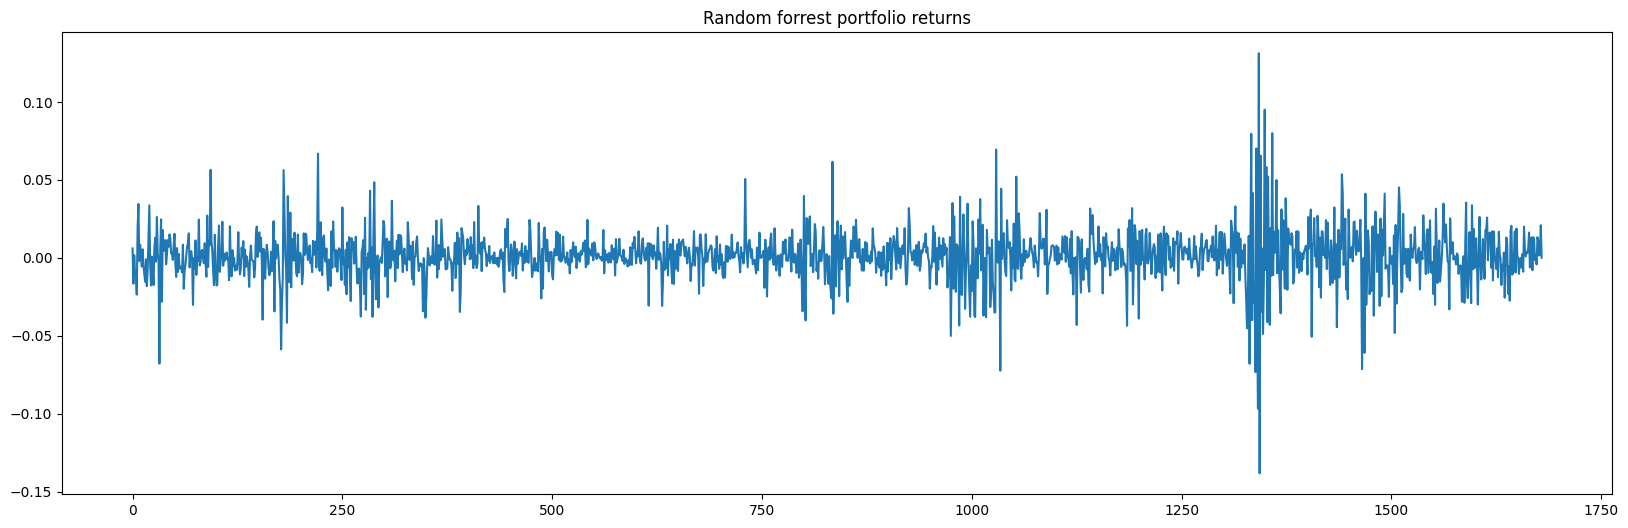

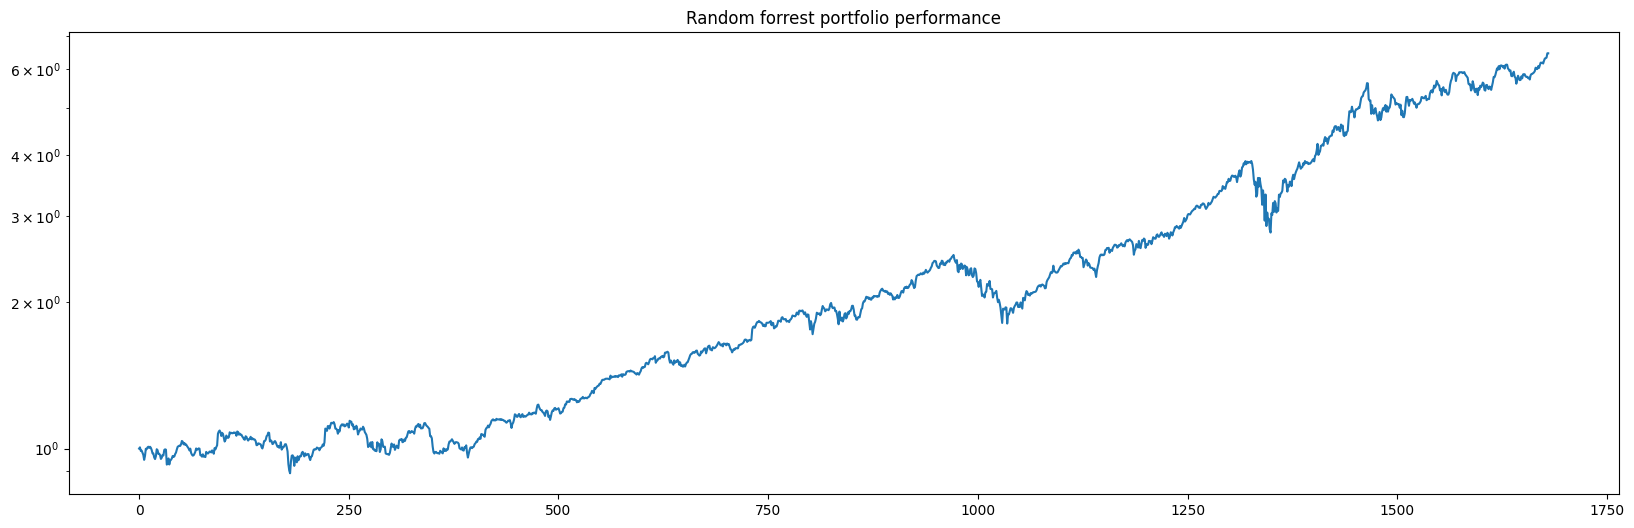

In [32]:
plt.figure(figsize=(20, 6))
plt.plot(povrat_rf)
plt.title("Random forrest portfolio returns")
#plt.xticks(np.arange(0, len(povrat_sample), 252), np.arange(2001, 2022, 1))
plt.show()

plt.figure(figsize=(20, 6))
plt.semilogy([item if isinstance(item, (int, float)) else item[0] for item in ukupno_rf])
plt.title("Random forrest portfolio performance")
#plt.xticks(np.arange(0, len(ukupno_sample), 252), np.arange(2001, 2022, 1))
plt.show()

In [33]:
#log(R"2)
features = []
next_month_volatility = []

for i in range(start - rf_window*2):
        for stock in selected_stocks:
            features.append(np.log(returns_df[stock][i : i + rf_window] ** 2))
            next_month_volatility.append(np.log(returns_df[stock][i + rf_window : i + rf_window*2].var()))

# Razdvajanje podataka na skupove za treniranje i testiranje
features = np.clip(features, np.finfo(np.float32).min, np.finfo(np.float32).max)
X_train, X_test, y_train, y_test = train_test_split(features, next_month_volatility, test_size=0.2, random_state=42)

# Inicijalizacija i treniranje Random Forest regresijskog modela
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# K-fold unakrsna validacija
kf = KFold(n_splits=4, shuffle=True, random_state=42)  # 5-fold validacija, možete promijeniti broj foldova prema potrebi

mse_scores = []  # Lista za pohranu MSE vrijednosti za svaki fold

for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train)):
    X_train_fold = [X_train[i] for i in train_index]
    X_val_fold = [X_train[i] for i in test_index] 
    y_train_fold = [y_train[i] for i in train_index]
    y_val_fold = [y_train[i] for i in test_index]
    
    # Treniranje modela na trenirajućem skupu
    random_forest.fit(X_train_fold, y_train_fold)

    # Predviđanje volatilnosti na validacijskom skupu
    predicted_val_volatility = random_forest.predict(X_val_fold)

    # Računanje MSE za trenutni fold
    fold_mse = mean_squared_error(y_val_fold, predicted_val_volatility)
    mse_scores.append(fold_mse)

# Srednja vrijednost MSE za sve foldove
average_mse = sum(mse_scores) / len(mse_scores)

# Ispis srednje vrijednosti MSE
print(f"Srednja vrijednost MSE za {kf.n_splits}-fold unakrsnu validaciju: {average_mse}")
# Predviđanje volatilnosti sljedećeg mjeseca
predicted_volatility = random_forest.predict(X_test)

# Evaluacija modela
rf_mse = mean_squared_error(y_test, predicted_volatility)


ukupno_rf = [1]
povrat_rf = []



#za svaki mjesec se pomicemo i racunamo volatilnost u intervalu godinu dana
for i in range(start, end - 9, 21):
    volatility = {}
    #volatility = np.clip(volatility, np.finfo(np.float32).min, np.finfo(np.float32).max)

    for stock in selected_stocks:
        window_returns = returns_df[stock][i - rf_window:i]
        window_returns = np.log(window_returns[::-1] ** 2)
        window_returns = np.clip(window_returns, np.finfo(np.float32).min, np.finfo(np.float32).max)

        temp = np.exp(random_forest.predict(np.array(window_returns).reshape(1, -1))) ** 0.5 
        volatility[stock] = temp

    #racunamo tezine s obzirom na volatilnost
    weights = get_portf_weights(volatility) # 1/len(volatilnost)
    #za svaki dan racunamo promjenu u portfelju
    

    vector = weights
    rf_returns = np.dot(matrix[i:i+rf_window], vector)
    for ret in rf_returns:
        povrat_rf.append(ret)
        ukupno_rf.append((ret+1)*ukupno_rf[-1])

random_forest_portfolio = ["Rand Forr Portfolio log(R^2)" + str(rf_window)]

random_forest_df = pd.DataFrame(povrat_rf)

rf_std = random_forest_df.std() * 252**0.5
rf_return = (1 + random_forest_df.mean())**252 - 1
rf_sharpe = rf_return[0] / rf_std[0]

random_forest_portfolio.append(rf_std[0])
random_forest_portfolio.append(rf_return[0])
random_forest_portfolio.append(rf_sharpe)
random_forest_portfolio.append(rf_mse)
portfolio_df.append(random_forest_portfolio)

c:\Users\filip\miniconda3\envs\everything\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


KeyboardInterrupt: 

In [ ]:
#R"2
features = []
next_month_volatility = []

for i in range(start - rf_window*2):
        for stock in selected_stocks:
            features.append(returns_df[stock][i : i + rf_window] ** 2)
            next_month_volatility.append(np.log(returns_df[stock][i + rf_window : i + rf_window*2].var()))

# Razdvajanje podataka na skupove za treniranje i testiranje
X_train, X_test, y_train, y_test = train_test_split(features, next_month_volatility, test_size=0.1, random_state=42)

# Inicijalizacija i treniranje Random Forest regresijskog modela
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# K-fold unakrsna validacija
kf = KFold(n_splits=4, shuffle=True, random_state=42)  # 5-fold validacija, možete promijeniti broj foldova prema potrebi

mse_scores = []  # Lista za pohranu MSE vrijednosti za svaki fold

for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train)):
    X_train_fold = [X_train[i] for i in train_index]
    X_val_fold = [X_train[i] for i in test_index] 
    y_train_fold = [y_train[i] for i in train_index]
    y_val_fold = [y_train[i] for i in test_index]

    # Treniranje modela na trenirajućem skupu
    random_forest.fit(X_train_fold, y_train_fold)

    # Predviđanje volatilnosti na validacijskom skupu
    predicted_val_volatility = random_forest.predict(X_val_fold)

    # Računanje MSE za trenutni fold
    fold_mse = mean_squared_error(y_val_fold, predicted_val_volatility)
    mse_scores.append(fold_mse)

# Srednja vrijednost MSE za sve foldove
average_mse = sum(mse_scores) / len(mse_scores)

# Ispis srednje vrijednosti MSE
print(f"Srednja vrijednost MSE za {kf.n_splits}-fold unakrsnu validaciju: {average_mse}")

# Predviđanje volatilnosti sljedećeg mjeseca
predicted_volatility = random_forest.predict(X_test)

# Evaluacija modela
rf_mse = mean_squared_error(y_test, predicted_volatility)


ukupno_rf = [1]
povrat_rf = []



#za svaki mjesec se pomicemo i racunamo volatilnost u intervalu godinu dana
for i in range(start, end - 9, 21):
    volatility = {}
    for stock in selected_stocks:
        window_returns = returns_df[stock][i - rf_window:i]
        window_returns = window_returns[::-1] ** 2
        volatility[stock] = np.exp(random_forest.predict(np.array(window_returns).reshape(1, -1))) ** 0.5
    
    #racunamo tezine s obzirom na volatilnost
    weights = get_portf_weights(volatility) # 1/len(volatilnost)
    #za svaki dan racunamo promjenu u portfelju
    

    vector = weights
    rf_returns = np.dot(matrix[i:i+rf_window], vector)
    for ret in rf_returns:
        povrat_rf.append(ret)
        ukupno_rf.append((ret+1)*ukupno_rf[-1])

random_forest_portfolio = ["Rand Forr Portfolio R^2" + str(rf_window)]

random_forest_df = pd.DataFrame(povrat_rf)

rf_std = random_forest_df.std() * 252**0.5
rf_return = (1 + random_forest_df.mean())**252 - 1
rf_sharpe = rf_return[0] / rf_std[0]

random_forest_portfolio.append(rf_std[0])
random_forest_portfolio.append(rf_return[0])
random_forest_portfolio.append(rf_sharpe)
random_forest_portfolio.append(rf_mse)
portfolio_df.append(random_forest_portfolio)

In [ ]:
features = []
next_month_volatility = []

for i in range(start - rf_window*2):
        for stock in selected_stocks:
            features.append(abs(returns_df[stock][i : i + rf_window]))
            next_month_volatility.append(np.log(returns_df[stock][i + rf_window : i + rf_window*2].var()))

# Razdvajanje podataka na skupove za treniranje i testiranje
X_train, X_test, y_train, y_test = train_test_split(features, next_month_volatility, test_size=0.2, random_state=42)

# Inicijalizacija i treniranje Random Forest regresijskog modela
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# K-fold unakrsna validacija
kf = KFold(n_splits=4, shuffle=True, random_state=42)  # 5-fold validacija, možete promijeniti broj foldova prema potrebi

mse_scores = []  # Lista za pohranu MSE vrijednosti za svaki fold

for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train)):
    X_train_fold = [X_train[i] for i in train_index]
    X_val_fold = [X_train[i] for i in test_index] 
    y_train_fold = [y_train[i] for i in train_index]
    y_val_fold = [y_train[i] for i in test_index]

    # Treniranje modela na trenirajućem skupu
    random_forest.fit(X_train_fold, y_train_fold)

    # Predviđanje volatilnosti na validacijskom skupu
    predicted_val_volatility = random_forest.predict(X_val_fold)

    # Računanje MSE za trenutni fold
    fold_mse = mean_squared_error(y_val_fold, predicted_val_volatility)
    mse_scores.append(fold_mse)

# Srednja vrijednost MSE za sve foldove
average_mse = sum(mse_scores) / len(mse_scores)

# Ispis srednje vrijednosti MSE
print(f"Srednja vrijednost MSE za {kf.n_splits}-fold unakrsnu validaciju: {average_mse}")

# Predviđanje volatilnosti sljedećeg mjeseca
predicted_volatility = random_forest.predict(X_test)

# Evaluacija modela
rf_mse = mean_squared_error(y_test, predicted_volatility)


ukupno_rf = [1]
povrat_rf = []



#za svaki mjesec se pomicemo i racunamo volatilnost u intervalu godinu dana
for i in range(start, end - 9, 21):
    volatility = {}
    for stock in selected_stocks:
        window_returns = returns_df[stock][i - rf_window:i]
        window_returns = abs(window_returns[::-1])
        volatility[stock] = np.exp(random_forest.predict(np.array(window_returns).reshape(1, -1)))
    
    #racunamo tezine s obzirom na volatilnost
    weights = get_portf_weights(volatility) # 1/len(volatilnost)
    #za svaki dan racunamo promjenu u portfelju
    

    vector = weights
    rf_returns = np.dot(matrix[i:i+rf_window], vector)
    for ret in rf_returns:
        povrat_rf.append(ret)
        ukupno_rf.append((ret+1)*ukupno_rf[-1])

random_forest_portfolio = ["Rand Forr Portfolio |R|" + str(rf_window)]

random_forest_df = pd.DataFrame(povrat_rf)

rf_std = random_forest_df.std() * 252**0.5
rf_return = (1 + random_forest_df.mean())**252 - 1
rf_sharpe = rf_return[0] / rf_std[0]

random_forest_portfolio.append(rf_std[0])
random_forest_portfolio.append(rf_return[0])
random_forest_portfolio.append(rf_sharpe)
random_forest_portfolio.append(rf_mse)
portfolio_df.append(random_forest_portfolio)

[   8   12   14 ... 5972 5976 5978]
[   0    6   18 ... 5975 5977 5979]
[   1    7   11 ... 5961 5963 5969]
[   2    3    4 ... 5966 5968 5971]
